In [17]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor
from torchinfo import summary
from torch.optim import Adam
from torchvision.utils import save_image

from tqdm import tqdm

# Data Loading

In [18]:
class SkyDataset(Dataset):
    def __init__(self, train_dir, gt_dir):
        self.train_dir = train_dir
        self.gt_dir = gt_dir
        
        self.gt_imgs = os.listdir(gt_dir) # image filename
        self.gt_paths = [os.path.join(self.gt_dir, self.gt_imgs[x]) for x in range(len(self.gt_imgs))] # total path
        
        self.gt = []
        self.train = []
        
        pattern = r'^([A-Za-z0-9_-]+)\_\d+\.jpg$'
        for idx, gt_img_fname in enumerate(self.gt_imgs):
            match = re.search(pattern, gt_img_fname)
            if match:
                data_folder = match.group(1)    
                data_imgs = sorted(os.listdir(os.path.join(self.train_dir, data_folder, gt_img_fname[:-4])))
                data_paths = [os.path.join(self.train_dir, data_folder, gt_img_fname[:-4], x) for x in data_imgs]
                if len(data_paths) > 5:
                    self.gt.append(self.gt_paths[idx])
                    self.train.append(data_paths)

    def __len__(self):
        return len(self.gt)
    
    def __getitem__(self, idx):
        train_seq = torch.stack([read_image(x)/255.0 for x in self.train[idx][:5]])
        gt_image = read_image(self.gt[idx])/255.0
        
        return train_seq, gt_image

In [19]:
train_set = SkyDataset('/kaggle/input/aps360-sky-train-dataset/sky_train', '/kaggle/input/aps360-sky-train-dataset/ground_truth/ground_truth')
train_dataloader = DataLoader(train_set, batch_size=2, shuffle=True)

torch.Size([2, 5, 3, 360, 640]) torch.Size([2, 3, 360, 640])


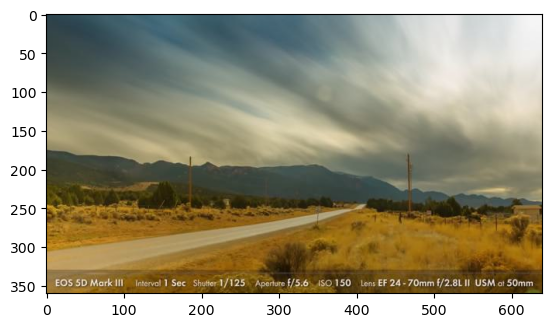

tensor([[[[0.2039, 0.2078, 0.2078,  ..., 0.9725, 0.9725, 0.9725],
          [0.2039, 0.2078, 0.2078,  ..., 0.9725, 0.9725, 0.9725],
          [0.2118, 0.2118, 0.2078,  ..., 0.9725, 0.9725, 0.9725],
          ...,
          [0.6510, 0.6510, 0.6275,  ..., 0.3804, 0.3765, 0.3765],
          [0.6275, 0.6314, 0.6353,  ..., 0.3922, 0.3765, 0.3686],
          [0.6431, 0.6275, 0.6275,  ..., 0.4039, 0.3882, 0.3725]],

         [[0.2863, 0.2902, 0.2902,  ..., 0.9686, 0.9686, 0.9686],
          [0.2863, 0.2902, 0.2902,  ..., 0.9686, 0.9686, 0.9686],
          [0.2863, 0.2863, 0.2902,  ..., 0.9686, 0.9686, 0.9686],
          ...,
          [0.4980, 0.4980, 0.4706,  ..., 0.3216, 0.3059, 0.3059],
          [0.4745, 0.4784, 0.4784,  ..., 0.3569, 0.3333, 0.3255],
          [0.4902, 0.4745, 0.4706,  ..., 0.3843, 0.3529, 0.3373]],

         [[0.3059, 0.3098, 0.3098,  ..., 0.9882, 0.9882, 0.9882],
          [0.3059, 0.3098, 0.3098,  ..., 0.9882, 0.9882, 0.9882],
          [0.3098, 0.3098, 0.3098,  ..., 0

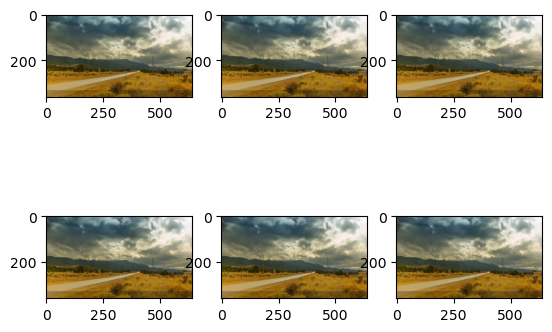

In [20]:
in_seq, gt_img = next(iter(train_dataloader))
print(in_seq.shape, gt_img.shape)
plt.imshow(gt_img[0].squeeze().permute(1, 2, 0))
plt.show()
f, axarr = plt.subplots(2,3) 
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(in_seq[0].squeeze()[0].cpu().permute(1, 2, 0))
print(in_seq.squeeze()[0])

torch.cuda.empty_cache()

# Model Construction

In [21]:
class ConvLSTMCell(nn.Module):
    """
    ConvLSTM Cell based on https://holmdk.github.io/2020/04/02/video_prediction.html
    """
    def __init__(self, input_dim, nf, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.nf = nf
        padding = kernel_size[0] // 2
        self.conv = nn.Conv2d(self.input_dim + self.nf, 4 * self.nf, kernel_size, padding=padding)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        x = torch.cat([input_tensor, h_cur], dim=1)
        x = self.conv(x)

        cc_i, cc_f, cc_o, cc_g = torch.split(x, self.nf, dim=1)
        i = F.LeakyRelu(cc_i)
        f = F.LeakyRelu(cc_f)
        o = F.LeakyRelu(cc_o)
        g = F.LeakyRelu(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * F.LeakyRelu(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


In [22]:

class AEConvLSTM(nn.Module):
    def __init__(self, nf, in_c):
        super(AEConvLSTM, self).__init__()
        self.nf = nf
        self.e1 = ConvLSTMCell(in_c, nf, 3)
        self.e2 = ConvLSTMCell(nf, nf, 3)
        self.d1 = ConvLSTMCell(nf, nf, 3)
        self.d2 = ConvLSTMCell(nf, nf, 3)
        self.d3 = nn.Conv3d(nf, 3, 3, 1)

    def forward(self, x, preds, hidden_state=None):
        b, seq_len, _, h, w = x.size()

        out1, hidden1 = self.e1.init_hidden(b, (h, w))
        out2, hidden2 = self.e2.init_hidden(b, (h, w))
        out3, hidden3 = self.d1.init_hidden(b, (h, w))
        out4, hidden4 = self.d2.init_hidden(b, (h, w))

        outputs = []
        for t in range(seq_len):
            out1, hidden1 = self.e1(x[:, t, :, :], [out1, hidden1])
            out2, hidden2 = self.e2(out2, [out2, hidden2])
        for t in range(preds):
            out3, hidden3 = self.decoder_1_convlstm(out2,[out3, hidden3])
            out4, hidden4 = self.decoder_2_convlstm(out3, [out4, hidden4])
            outputs += [out4]  # predictions
        outputs = torch.stack(outputs, 1)
        outputs = self.decoder_CNN(outputs.permute(0, 2, 1, 3, 4))
        outputs = torch.nn.Sigmoid()(outputs)

        return outputs


# Train

### Hyperparams

In [24]:
lr=1e-4
num_epochs=50
img_w = 640
img_h = 360

In [25]:
plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [26]:
def train_net(net):
    criterion = nn.MSELoss()
    
    train_loss = []
    
    for epoch in range(num_epochs):
        total_loss = 0

        for inputs, gts in tqdm(train_dataloader):
            inputs = inputs.cuda()
            gts = gts.cuda()

            preds = net(inputs, pred_num=50)
            preds = torch.mean(preds, dim=2)
            
            loss = criterion(preds, gts)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.item()
        
        train_loss.append(float(total_loss) / len(train_dataloader))
        print(("Epoch {}: Train loss: {}"). format(epoch + 1,train_loss[epoch]))
        torch.save(net.state_dict(), f'/kaggle/working/check_{epoch}.pth')
        plt.figure()
        plt.plot(range(epoch+1), train_loss)
        plt.savefig(f'/kaggle/working/loss_{epoch}.jpg')
#         plt.imsave(f'/kaggle/working/input_{epoch}.jpg', inputs[0].detach().cpu().permute(1,2,0))
#         plt.imsave(f'/kaggle/working/pred_{epoch}.jpg', preds[0].detach().cpu().permute(1,2,0))
#         plt.imsave(f'/kaggle/working/gt_{epoch}.jpg', gts[0].detach().cpu().permute(1,2,0))


In [27]:
net1 = AEConvLSTM(nf = 10, in_chan = 3)
net1 = net1.cuda()
optimizer = Adam(net1.parameters(), lr)

In [28]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_net(net1)

  0%|          | 0/665 [00:00<?, ?it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 1/665 [00:00<09:23,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 2/665 [00:01<09:17,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 3/665 [00:02<09:12,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 4/665 [00:03<09:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 5/665 [00:04<09:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 6/665 [00:04<09:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 7/665 [00:05<09:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 8/665 [00:06<08:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|▏         | 9/665 [00:07<08:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 10/665 [00:08<08:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 11/665 [00:09<08:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 12/665 [00:09<08:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 13/665 [00:10<08:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 14/665 [00:11<08:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 15/665 [00:12<08:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 16/665 [00:13<08:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 17/665 [00:13<08:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 18/665 [00:14<08:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 19/665 [00:15<08:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 20/665 [00:16<08:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 21/665 [00:17<08:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 22/665 [00:18<08:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 23/665 [00:18<08:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▎         | 24/665 [00:19<08:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 25/665 [00:20<08:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 26/665 [00:21<08:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 27/665 [00:22<08:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 28/665 [00:23<08:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 29/665 [00:23<08:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 30/665 [00:24<08:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 31/665 [00:25<08:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 32/665 [00:26<08:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 33/665 [00:27<08:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 34/665 [00:28<08:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 35/665 [00:28<08:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 36/665 [00:29<08:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 37/665 [00:30<08:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 38/665 [00:31<08:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 39/665 [00:32<08:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 40/665 [00:32<08:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 41/665 [00:33<08:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▋         | 42/665 [00:34<08:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▋         | 43/665 [00:35<08:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 44/665 [00:36<08:28,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 45/665 [00:37<08:29,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 46/665 [00:37<08:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 47/665 [00:38<08:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 48/665 [00:39<08:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 49/665 [00:40<08:22,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 50/665 [00:41<08:21,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 51/665 [00:41<08:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 52/665 [00:42<08:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 53/665 [00:43<08:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 54/665 [00:44<08:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 55/665 [00:45<08:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 56/665 [00:46<08:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▊         | 57/665 [00:46<08:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▊         | 58/665 [00:47<08:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 59/665 [00:48<08:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 60/665 [00:49<08:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 61/665 [00:50<08:13,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 62/665 [00:51<08:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 63/665 [00:51<08:13,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 64/665 [00:52<08:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 65/665 [00:53<08:11,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 66/665 [00:54<08:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 67/665 [00:55<08:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 68/665 [00:55<08:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 69/665 [00:56<08:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 70/665 [00:57<08:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 71/665 [00:58<08:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 72/665 [00:59<08:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 73/665 [01:00<08:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 74/665 [01:00<08:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█▏        | 75/665 [01:01<08:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█▏        | 76/665 [01:02<08:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 77/665 [01:03<08:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 78/665 [01:04<08:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 79/665 [01:04<07:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 80/665 [01:05<07:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 81/665 [01:06<07:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 82/665 [01:07<08:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 83/665 [01:08<08:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 84/665 [01:09<07:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 85/665 [01:09<08:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 86/665 [01:10<07:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 87/665 [01:11<07:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 88/665 [01:12<07:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 89/665 [01:13<07:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▎        | 90/665 [01:14<07:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▎        | 91/665 [01:14<07:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 92/665 [01:15<07:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 93/665 [01:16<07:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 94/665 [01:17<07:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 95/665 [01:18<07:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 96/665 [01:19<07:54,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 97/665 [01:19<07:51,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 98/665 [01:20<07:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 99/665 [01:21<07:50,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 100/665 [01:22<07:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 101/665 [01:23<07:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 102/665 [01:24<07:47,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 103/665 [01:24<07:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 104/665 [01:25<07:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 105/665 [01:26<07:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 106/665 [01:27<07:47,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 107/665 [01:28<07:43,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 108/665 [01:29<07:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▋        | 109/665 [01:29<07:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 110/665 [01:30<07:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 111/665 [01:31<07:40,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 112/665 [01:32<07:40,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 113/665 [01:33<07:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 114/665 [01:33<07:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 115/665 [01:34<07:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 116/665 [01:35<07:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 117/665 [01:36<07:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 118/665 [01:37<07:29,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 119/665 [01:38<07:27,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 120/665 [01:38<07:28,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 121/665 [01:39<07:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 122/665 [01:40<07:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 123/665 [01:41<07:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▊        | 124/665 [01:42<07:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 125/665 [01:43<07:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 126/665 [01:43<07:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 127/665 [01:44<07:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 128/665 [01:45<07:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 129/665 [01:46<07:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 130/665 [01:47<07:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 131/665 [01:47<07:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 132/665 [01:48<07:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 133/665 [01:49<07:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 134/665 [01:50<07:21,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 135/665 [01:51<07:22,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 136/665 [01:52<07:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 137/665 [01:52<07:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 138/665 [01:53<07:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 139/665 [01:54<07:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 140/665 [01:55<07:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 141/665 [01:56<07:15,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██▏       | 142/665 [01:57<07:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 143/665 [01:57<07:14,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 144/665 [01:58<07:13,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 145/665 [01:59<07:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 146/665 [02:00<07:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 147/665 [02:01<07:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 148/665 [02:02<07:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 149/665 [02:02<07:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 150/665 [02:03<07:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 151/665 [02:04<07:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 152/665 [02:05<07:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 153/665 [02:06<07:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 154/665 [02:06<07:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 155/665 [02:07<07:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 156/665 [02:08<06:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▎       | 157/665 [02:09<06:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 158/665 [02:10<06:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 159/665 [02:11<06:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 160/665 [02:11<06:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 161/665 [02:12<06:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 162/665 [02:13<06:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 163/665 [02:14<06:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 164/665 [02:15<06:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 165/665 [02:16<06:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 166/665 [02:16<06:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 167/665 [02:17<06:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 168/665 [02:18<06:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 169/665 [02:19<06:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 170/665 [02:20<06:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 171/665 [02:20<06:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 172/665 [02:21<06:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 173/665 [02:22<06:49,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 174/665 [02:23<06:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▋       | 175/665 [02:24<06:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▋       | 176/665 [02:25<06:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 177/665 [02:25<06:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 178/665 [02:26<06:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 179/665 [02:27<06:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 180/665 [02:28<06:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 181/665 [02:29<06:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 182/665 [02:30<06:37,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 183/665 [02:30<06:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 184/665 [02:31<06:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 185/665 [02:32<06:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 186/665 [02:33<06:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 187/665 [02:34<06:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 188/665 [02:34<06:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 189/665 [02:35<06:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▊       | 190/665 [02:36<06:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▊       | 191/665 [02:37<06:33,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 192/665 [02:38<06:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 193/665 [02:39<06:33,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 194/665 [02:39<06:32,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 195/665 [02:40<06:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 196/665 [02:41<06:30,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 197/665 [02:42<06:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 198/665 [02:43<06:28,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 199/665 [02:44<06:27,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 200/665 [02:44<06:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 201/665 [02:45<06:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 202/665 [02:46<06:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 203/665 [02:47<06:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 204/665 [02:48<06:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 205/665 [02:49<06:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 206/665 [02:49<06:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 207/665 [02:50<06:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███▏      | 208/665 [02:51<06:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███▏      | 209/665 [02:52<06:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 210/665 [02:53<06:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 211/665 [02:54<06:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 212/665 [02:54<06:17,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 213/665 [02:55<06:20,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 214/665 [02:56<06:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 215/665 [02:57<06:13,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 216/665 [02:58<06:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 217/665 [02:59<06:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 218/665 [02:59<06:11,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 219/665 [03:00<06:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 220/665 [03:01<06:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 221/665 [03:02<06:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 222/665 [03:03<06:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▎      | 223/665 [03:03<06:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▎      | 224/665 [03:04<06:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 225/665 [03:05<06:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 226/665 [03:06<06:06,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 227/665 [03:07<06:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 228/665 [03:08<06:03,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 229/665 [03:08<06:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 230/665 [03:09<05:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 231/665 [03:10<05:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 232/665 [03:11<05:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 233/665 [03:12<05:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 234/665 [03:13<05:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 235/665 [03:13<05:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 236/665 [03:14<05:56,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 237/665 [03:15<05:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 238/665 [03:16<05:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 239/665 [03:17<05:53,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 240/665 [03:18<05:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 241/665 [03:18<05:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▋      | 242/665 [03:19<05:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 243/665 [03:20<05:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 244/665 [03:21<05:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 245/665 [03:22<05:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 246/665 [03:22<05:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 247/665 [03:23<05:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 248/665 [03:24<05:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 249/665 [03:25<05:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 250/665 [03:26<05:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 251/665 [03:27<05:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 252/665 [03:27<05:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 253/665 [03:28<05:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 254/665 [03:29<05:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 255/665 [03:30<05:40,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 256/665 [03:31<05:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▊      | 257/665 [03:32<05:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 258/665 [03:32<05:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 259/665 [03:33<05:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 260/665 [03:34<05:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 261/665 [03:35<05:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 262/665 [03:36<05:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 263/665 [03:37<05:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 264/665 [03:37<05:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 265/665 [03:38<05:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 266/665 [03:39<05:31,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 267/665 [03:40<05:30,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 268/665 [03:41<05:30,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 269/665 [03:42<05:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 270/665 [03:42<05:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 271/665 [03:43<05:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 272/665 [03:44<05:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 273/665 [03:45<05:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 274/665 [03:46<05:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████▏     | 275/665 [03:46<05:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 276/665 [03:47<05:19,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 277/665 [03:48<05:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 278/665 [03:49<05:16,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 279/665 [03:50<05:20,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 280/665 [03:51<05:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 281/665 [03:51<05:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 282/665 [03:52<05:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 283/665 [03:53<05:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 284/665 [03:54<05:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 285/665 [03:55<05:31,  1.15it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 286/665 [03:56<05:24,  1.17it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 287/665 [03:57<05:22,  1.17it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 288/665 [03:57<05:19,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 289/665 [03:58<05:17,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▎     | 290/665 [03:59<05:13,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 291/665 [04:00<05:12,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 292/665 [04:01<05:14,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 293/665 [04:02<05:10,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 294/665 [04:02<05:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 295/665 [04:03<05:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 296/665 [04:04<05:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 297/665 [04:05<05:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 298/665 [04:06<05:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 299/665 [04:06<05:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 300/665 [04:07<05:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 301/665 [04:08<05:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 302/665 [04:09<04:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 303/665 [04:10<04:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 304/665 [04:11<04:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 305/665 [04:11<04:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 306/665 [04:12<04:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 307/665 [04:13<04:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▋     | 308/665 [04:14<04:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▋     | 309/665 [04:15<04:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 310/665 [04:16<04:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 311/665 [04:16<04:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 312/665 [04:17<04:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 313/665 [04:18<04:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 314/665 [04:19<04:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 315/665 [04:20<04:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 316/665 [04:20<04:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 317/665 [04:21<04:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 318/665 [04:22<04:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 319/665 [04:23<04:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 320/665 [04:24<04:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 321/665 [04:25<04:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 322/665 [04:25<04:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▊     | 323/665 [04:26<04:43,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▊     | 324/665 [04:27<04:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 325/665 [04:28<04:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 326/665 [04:29<04:41,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 327/665 [04:30<04:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 328/665 [04:30<04:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 329/665 [04:31<04:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 330/665 [04:32<04:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 331/665 [04:33<04:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 332/665 [04:34<04:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 333/665 [04:34<04:33,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 334/665 [04:35<04:34,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 335/665 [04:36<04:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 336/665 [04:37<04:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 337/665 [04:38<04:29,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 338/665 [04:39<04:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 339/665 [04:39<04:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 340/665 [04:40<04:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████▏    | 341/665 [04:41<04:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████▏    | 342/665 [04:42<04:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 343/665 [04:43<04:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 344/665 [04:44<04:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 345/665 [04:44<04:25,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 346/665 [04:45<04:25,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 347/665 [04:46<04:25,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 348/665 [04:47<04:24,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 349/665 [04:48<04:23,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 350/665 [04:49<04:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 351/665 [04:49<04:21,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 352/665 [04:50<04:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 353/665 [04:51<04:19,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 354/665 [04:52<04:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 355/665 [04:53<04:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▎    | 356/665 [04:54<04:17,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▎    | 357/665 [04:54<04:15,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 358/665 [04:55<04:15,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 359/665 [04:56<04:15,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 360/665 [04:57<04:13,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 361/665 [04:58<04:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 362/665 [04:59<04:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 363/665 [04:59<04:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 364/665 [05:00<04:11,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 365/665 [05:01<04:09,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 366/665 [05:02<04:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 367/665 [05:03<04:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 368/665 [05:03<04:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 369/665 [05:04<04:06,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 370/665 [05:05<04:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 371/665 [05:06<04:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 372/665 [05:07<04:03,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 373/665 [05:08<04:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 374/665 [05:08<04:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▋    | 375/665 [05:09<04:01,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 376/665 [05:10<04:00,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 377/665 [05:11<03:59,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 378/665 [05:12<03:58,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 379/665 [05:13<03:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 380/665 [05:13<03:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 381/665 [05:14<03:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 382/665 [05:15<03:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 383/665 [05:16<03:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 384/665 [05:17<03:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 385/665 [05:18<03:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 386/665 [05:18<03:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 387/665 [05:19<03:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 388/665 [05:20<03:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 389/665 [05:21<03:50,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▊    | 390/665 [05:22<03:49,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 391/665 [05:23<03:47,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 392/665 [05:23<03:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 393/665 [05:24<03:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 394/665 [05:25<03:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 395/665 [05:26<03:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 396/665 [05:27<03:43,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 397/665 [05:28<03:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 398/665 [05:28<03:42,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 399/665 [05:29<03:40,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 400/665 [05:30<03:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 401/665 [05:31<03:39,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 402/665 [05:32<03:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 403/665 [05:32<03:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 404/665 [05:33<03:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 405/665 [05:34<03:33,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 406/665 [05:35<03:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 407/665 [05:36<03:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████▏   | 408/665 [05:37<03:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 409/665 [05:37<03:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 410/665 [05:38<03:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 411/665 [05:39<03:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 412/665 [05:40<03:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 413/665 [05:41<03:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 414/665 [05:42<03:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 415/665 [05:42<03:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 416/665 [05:43<03:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 417/665 [05:44<03:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 418/665 [05:45<03:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 419/665 [05:46<03:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 420/665 [05:46<03:20,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 421/665 [05:47<03:19,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 422/665 [05:48<03:19,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▎   | 423/665 [05:49<03:19,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 424/665 [05:50<03:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 425/665 [05:51<03:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 426/665 [05:51<03:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 427/665 [05:52<03:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 428/665 [05:53<03:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 429/665 [05:54<03:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 430/665 [05:55<03:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 431/665 [05:55<03:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 432/665 [05:56<03:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 433/665 [05:57<03:12,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 434/665 [05:58<03:12,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 435/665 [05:59<03:10,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 436/665 [06:00<03:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 437/665 [06:00<03:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 438/665 [06:01<03:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 439/665 [06:02<03:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 440/665 [06:03<03:06,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▋   | 441/665 [06:04<03:07,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▋   | 442/665 [06:05<03:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 443/665 [06:05<03:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 444/665 [06:06<03:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 445/665 [06:07<03:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 446/665 [06:08<03:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 447/665 [06:09<02:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 448/665 [06:10<02:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 449/665 [06:10<02:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 450/665 [06:11<02:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 451/665 [06:12<02:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 452/665 [06:13<02:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 453/665 [06:14<02:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 454/665 [06:15<02:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 455/665 [06:15<02:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▊   | 456/665 [06:16<02:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▊   | 457/665 [06:17<02:52,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 458/665 [06:18<02:52,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 459/665 [06:19<02:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 460/665 [06:20<02:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 461/665 [06:20<02:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 462/665 [06:21<02:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 463/665 [06:22<02:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 464/665 [06:23<02:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 465/665 [06:24<02:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 466/665 [06:24<02:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 467/665 [06:25<02:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 468/665 [06:26<02:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 469/665 [06:27<02:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 470/665 [06:28<02:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 471/665 [06:29<02:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 472/665 [06:29<02:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 473/665 [06:30<02:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████▏  | 474/665 [06:31<02:37,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████▏  | 475/665 [06:32<02:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 476/665 [06:33<02:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 477/665 [06:34<02:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 478/665 [06:34<02:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 479/665 [06:35<02:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 480/665 [06:36<02:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 481/665 [06:37<02:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 482/665 [06:38<02:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 483/665 [06:39<02:31,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 484/665 [06:39<02:31,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 485/665 [06:40<02:29,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 486/665 [06:41<02:28,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 487/665 [06:42<02:28,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 488/665 [06:43<02:26,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▎  | 489/665 [06:44<02:26,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▎  | 490/665 [06:44<02:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 491/665 [06:45<02:24,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 492/665 [06:46<02:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 493/665 [06:47<02:23,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 494/665 [06:48<02:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 495/665 [06:48<02:21,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 496/665 [06:49<02:20,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 497/665 [06:50<02:19,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 498/665 [06:51<02:19,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 499/665 [06:52<02:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 500/665 [06:53<02:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 501/665 [06:53<02:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 502/665 [06:54<02:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 503/665 [06:55<02:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 504/665 [06:56<02:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 505/665 [06:57<02:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 506/665 [06:58<02:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 507/665 [06:58<02:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▋  | 508/665 [06:59<02:10,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 509/665 [07:00<02:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 510/665 [07:01<02:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 511/665 [07:02<02:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 512/665 [07:03<02:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 513/665 [07:03<02:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 514/665 [07:04<02:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 515/665 [07:05<02:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 516/665 [07:06<02:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 517/665 [07:07<02:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 518/665 [07:07<02:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 519/665 [07:08<02:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 520/665 [07:09<02:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 521/665 [07:10<01:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 522/665 [07:11<01:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▊  | 523/665 [07:12<01:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 524/665 [07:12<01:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 525/665 [07:13<01:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 526/665 [07:14<01:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 527/665 [07:15<01:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 528/665 [07:16<01:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 529/665 [07:17<01:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 530/665 [07:17<01:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 531/665 [07:18<01:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 532/665 [07:19<01:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 533/665 [07:20<01:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 534/665 [07:21<01:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 535/665 [07:22<01:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 536/665 [07:22<01:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 537/665 [07:23<01:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 538/665 [07:24<01:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 539/665 [07:25<01:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 540/665 [07:26<01:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████▏ | 541/665 [07:26<01:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 542/665 [07:27<01:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 543/665 [07:28<01:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 544/665 [07:29<01:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 545/665 [07:30<01:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 546/665 [07:31<01:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 547/665 [07:31<01:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 548/665 [07:32<01:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 549/665 [07:33<01:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 550/665 [07:34<01:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 551/665 [07:35<01:33,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 552/665 [07:36<01:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 553/665 [07:36<01:33,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 554/665 [07:37<01:33,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 555/665 [07:38<01:31,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▎ | 556/665 [07:39<01:30,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 557/665 [07:40<01:29,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 558/665 [07:41<01:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 559/665 [07:41<01:28,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 560/665 [07:42<01:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 561/665 [07:43<01:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 562/665 [07:44<01:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 563/665 [07:45<01:24,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 564/665 [07:46<01:24,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 565/665 [07:46<01:23,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 566/665 [07:47<01:22,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 567/665 [07:48<01:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 568/665 [07:49<01:21,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 569/665 [07:50<01:20,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 570/665 [07:51<01:19,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 571/665 [07:51<01:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 572/665 [07:52<01:17,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 573/665 [07:53<01:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▋ | 574/665 [07:54<01:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▋ | 575/665 [07:55<01:14,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 576/665 [07:56<01:14,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 577/665 [07:56<01:13,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 578/665 [07:57<01:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 579/665 [07:58<01:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 580/665 [07:59<01:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 581/665 [08:00<01:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 582/665 [08:01<01:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 583/665 [08:01<01:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 584/665 [08:02<01:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 585/665 [08:03<01:06,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 586/665 [08:04<01:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 587/665 [08:05<01:04,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 588/665 [08:05<01:03,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▊ | 589/665 [08:06<01:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▊ | 590/665 [08:07<01:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 591/665 [08:08<01:01,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 592/665 [08:09<01:01,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 593/665 [08:10<01:00,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 594/665 [08:11<00:59,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 595/665 [08:11<00:58,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 596/665 [08:12<00:57,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 597/665 [08:13<00:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 598/665 [08:14<00:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 599/665 [08:15<00:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 600/665 [08:15<00:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 601/665 [08:16<00:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 602/665 [08:17<00:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 603/665 [08:18<00:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 604/665 [08:19<00:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 605/665 [08:20<00:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 606/665 [08:20<00:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████▏| 607/665 [08:21<00:48,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████▏| 608/665 [08:22<00:47,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 609/665 [08:23<00:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 610/665 [08:24<00:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 611/665 [08:25<00:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 612/665 [08:25<00:44,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 613/665 [08:26<00:43,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 614/665 [08:27<00:42,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 615/665 [08:28<00:41,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 616/665 [08:29<00:40,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 617/665 [08:30<00:40,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 618/665 [08:30<00:39,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 619/665 [08:31<00:38,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 620/665 [08:32<00:37,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 621/665 [08:33<00:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▎| 622/665 [08:34<00:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▎| 623/665 [08:35<00:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 624/665 [08:35<00:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 625/665 [08:36<00:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 626/665 [08:37<00:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 627/665 [08:38<00:31,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 628/665 [08:39<00:30,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 629/665 [08:40<00:29,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 630/665 [08:40<00:29,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 631/665 [08:41<00:28,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 632/665 [08:42<00:27,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 633/665 [08:43<00:26,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 634/665 [08:44<00:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 635/665 [08:45<00:24,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 636/665 [08:45<00:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 637/665 [08:46<00:23,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 638/665 [08:47<00:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 639/665 [08:48<00:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 640/665 [08:49<00:20,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▋| 641/665 [08:50<00:19,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 642/665 [08:50<00:19,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 643/665 [08:51<00:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 644/665 [08:52<00:17,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 645/665 [08:53<00:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 646/665 [08:54<00:15,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 647/665 [08:55<00:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 648/665 [08:55<00:14,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 649/665 [08:56<00:13,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 650/665 [08:57<00:12,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 651/665 [08:58<00:11,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 652/665 [08:59<00:10,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 653/665 [09:00<00:09,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 654/665 [09:00<00:09,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 655/665 [09:01<00:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▊| 656/665 [09:02<00:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 657/665 [09:03<00:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 658/665 [09:04<00:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 659/665 [09:05<00:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 660/665 [09:05<00:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 661/665 [09:06<00:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 662/665 [09:07<00:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 663/665 [09:08<00:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 664/665 [09:09<00:00,  1.21it/s]

torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])


100%|██████████| 665/665 [09:09<00:00,  1.21it/s]


Epoch 1: Train loss: 0.033158925078333096


  0%|          | 0/665 [00:00<?, ?it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 1/665 [00:00<08:59,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 2/665 [00:01<09:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 3/665 [00:02<09:10,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 4/665 [00:03<09:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 5/665 [00:04<09:09,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 6/665 [00:04<09:09,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 7/665 [00:05<09:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 8/665 [00:06<09:06,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|▏         | 9/665 [00:07<09:04,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 10/665 [00:08<09:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 11/665 [00:09<08:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 12/665 [00:09<08:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 13/665 [00:10<08:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 14/665 [00:11<08:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 15/665 [00:12<08:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 16/665 [00:13<08:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 17/665 [00:14<08:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 18/665 [00:14<08:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 19/665 [00:15<08:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 20/665 [00:16<08:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 21/665 [00:17<08:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 22/665 [00:18<08:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 23/665 [00:18<08:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▎         | 24/665 [00:19<08:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 25/665 [00:20<08:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 26/665 [00:21<08:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 27/665 [00:22<08:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 28/665 [00:23<08:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 29/665 [00:23<08:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 30/665 [00:24<08:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 31/665 [00:25<08:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 32/665 [00:26<08:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 33/665 [00:27<08:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 34/665 [00:28<08:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 35/665 [00:28<08:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 36/665 [00:29<08:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 37/665 [00:30<08:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 38/665 [00:31<08:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 39/665 [00:32<08:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 40/665 [00:33<08:38,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 41/665 [00:33<08:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▋         | 42/665 [00:34<08:37,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▋         | 43/665 [00:35<08:36,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 44/665 [00:36<08:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 45/665 [00:37<08:36,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 46/665 [00:37<08:34,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 47/665 [00:38<08:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 48/665 [00:39<08:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 49/665 [00:40<08:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 50/665 [00:41<08:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 51/665 [00:42<08:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 52/665 [00:42<08:28,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 53/665 [00:43<08:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 54/665 [00:44<08:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 55/665 [00:45<08:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 56/665 [00:46<08:19,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▊         | 57/665 [00:47<08:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▊         | 58/665 [00:47<08:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 59/665 [00:48<08:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 60/665 [00:49<08:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 61/665 [00:50<08:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 62/665 [00:51<08:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 63/665 [00:52<08:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 64/665 [00:52<08:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 65/665 [00:53<08:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 66/665 [00:54<08:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 67/665 [00:55<08:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 68/665 [00:56<08:11,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 69/665 [00:56<08:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 70/665 [00:57<08:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 71/665 [00:58<08:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 72/665 [00:59<08:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 73/665 [01:00<08:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 74/665 [01:01<08:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█▏        | 75/665 [01:01<08:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█▏        | 76/665 [01:02<08:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 77/665 [01:03<08:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 78/665 [01:04<08:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 79/665 [01:05<08:06,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 80/665 [01:06<08:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 81/665 [01:06<08:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 82/665 [01:07<08:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 83/665 [01:08<07:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 84/665 [01:09<07:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 85/665 [01:10<08:02,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 86/665 [01:10<07:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 87/665 [01:11<08:00,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 88/665 [01:12<07:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 89/665 [01:13<07:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▎        | 90/665 [01:14<07:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▎        | 91/665 [01:15<07:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 92/665 [01:15<07:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 93/665 [01:16<07:56,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 94/665 [01:17<07:54,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 95/665 [01:18<07:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 96/665 [01:19<07:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 97/665 [01:20<07:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 98/665 [01:20<07:51,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 99/665 [01:21<07:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 100/665 [01:22<07:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 101/665 [01:23<07:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 102/665 [01:24<07:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 103/665 [01:25<07:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 104/665 [01:25<07:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 105/665 [01:26<07:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 106/665 [01:27<07:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 107/665 [01:28<07:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 108/665 [01:29<07:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▋        | 109/665 [01:29<07:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 110/665 [01:30<07:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 111/665 [01:31<07:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 112/665 [01:32<07:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 113/665 [01:33<07:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 114/665 [01:34<07:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 115/665 [01:34<07:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 116/665 [01:35<07:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 117/665 [01:36<07:35,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 118/665 [01:37<07:34,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 119/665 [01:38<07:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 120/665 [01:39<07:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 121/665 [01:39<07:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 122/665 [01:40<07:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 123/665 [01:41<07:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▊        | 124/665 [01:42<07:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 125/665 [01:43<07:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 126/665 [01:44<07:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 127/665 [01:44<07:20,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 128/665 [01:45<07:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 129/665 [01:46<07:19,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 130/665 [01:47<07:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 131/665 [01:48<07:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 132/665 [01:48<07:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 133/665 [01:49<07:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 134/665 [01:50<07:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 135/665 [01:51<07:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 136/665 [01:52<07:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 137/665 [01:53<07:14,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 138/665 [01:53<07:17,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 139/665 [01:54<07:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 140/665 [01:55<07:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 141/665 [01:56<07:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██▏       | 142/665 [01:57<07:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 143/665 [01:58<07:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 144/665 [01:58<07:07,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 145/665 [01:59<07:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 146/665 [02:00<07:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 147/665 [02:01<07:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 148/665 [02:02<07:01,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 149/665 [02:02<07:00,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 150/665 [02:03<07:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 151/665 [02:04<07:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 152/665 [02:05<07:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 153/665 [02:06<07:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 154/665 [02:07<07:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 155/665 [02:07<07:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 156/665 [02:08<06:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▎       | 157/665 [02:09<06:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 158/665 [02:10<06:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 159/665 [02:11<06:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 160/665 [02:11<06:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 161/665 [02:12<06:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 162/665 [02:13<06:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 163/665 [02:14<06:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 164/665 [02:15<06:56,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 165/665 [02:16<06:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 166/665 [02:16<06:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 167/665 [02:17<06:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 168/665 [02:18<06:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 169/665 [02:19<06:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 170/665 [02:20<06:51,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 171/665 [02:21<06:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 172/665 [02:21<06:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 173/665 [02:22<06:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 174/665 [02:23<06:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▋       | 175/665 [02:24<06:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▋       | 176/665 [02:25<06:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 177/665 [02:26<06:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 178/665 [02:26<06:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 179/665 [02:27<06:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 180/665 [02:28<06:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 181/665 [02:29<06:42,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 182/665 [02:30<06:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 183/665 [02:30<06:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 184/665 [02:31<06:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 185/665 [02:32<06:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 186/665 [02:33<06:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 187/665 [02:34<06:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 188/665 [02:35<06:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 189/665 [02:35<06:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▊       | 190/665 [02:36<06:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▊       | 191/665 [02:37<06:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 192/665 [02:38<06:28,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 193/665 [02:39<06:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 194/665 [02:40<06:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 195/665 [02:40<06:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 196/665 [02:41<06:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 197/665 [02:42<06:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 198/665 [02:43<06:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 199/665 [02:44<06:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 200/665 [02:45<06:26,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 201/665 [02:45<06:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 202/665 [02:46<06:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 203/665 [02:47<06:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 204/665 [02:48<06:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 205/665 [02:49<06:22,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 206/665 [02:49<06:21,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 207/665 [02:50<06:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███▏      | 208/665 [02:51<06:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███▏      | 209/665 [02:52<06:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 210/665 [02:53<06:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 211/665 [02:54<06:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 212/665 [02:54<06:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 213/665 [02:55<06:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 214/665 [02:56<06:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 215/665 [02:57<06:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 216/665 [02:58<06:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 217/665 [02:59<06:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 218/665 [02:59<06:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 219/665 [03:00<06:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 220/665 [03:01<06:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 221/665 [03:02<06:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 222/665 [03:03<06:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▎      | 223/665 [03:04<06:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▎      | 224/665 [03:04<06:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 225/665 [03:05<06:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 226/665 [03:06<06:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 227/665 [03:07<06:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 228/665 [03:08<06:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 229/665 [03:08<05:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 230/665 [03:09<05:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 231/665 [03:10<06:03,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 232/665 [03:11<06:09,  1.17it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 233/665 [03:12<06:05,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 234/665 [03:13<06:00,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 235/665 [03:13<05:58,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 236/665 [03:14<05:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 237/665 [03:15<05:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 238/665 [03:16<05:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 239/665 [03:17<05:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 240/665 [03:18<05:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 241/665 [03:18<05:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▋      | 242/665 [03:19<05:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 243/665 [03:20<05:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 244/665 [03:21<05:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 245/665 [03:22<05:48,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 246/665 [03:23<05:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 247/665 [03:23<05:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 248/665 [03:24<05:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 249/665 [03:25<05:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 250/665 [03:26<05:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 251/665 [03:27<05:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 252/665 [03:27<05:37,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 253/665 [03:28<05:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 254/665 [03:29<05:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 255/665 [03:30<05:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 256/665 [03:31<05:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▊      | 257/665 [03:32<05:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 258/665 [03:32<05:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 259/665 [03:33<05:33,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 260/665 [03:34<05:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 261/665 [03:35<05:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 262/665 [03:36<05:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 263/665 [03:37<05:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 264/665 [03:37<05:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 265/665 [03:38<05:28,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 266/665 [03:39<05:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 267/665 [03:40<05:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 268/665 [03:41<05:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 269/665 [03:41<05:28,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 270/665 [03:42<05:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 271/665 [03:43<05:27,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 272/665 [03:44<05:26,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 273/665 [03:45<05:26,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 274/665 [03:46<05:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████▏     | 275/665 [03:46<05:20,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 276/665 [03:47<05:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 277/665 [03:48<05:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 278/665 [03:49<05:15,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 279/665 [03:50<05:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 280/665 [03:51<05:14,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 281/665 [03:51<05:13,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 282/665 [03:52<05:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 283/665 [03:53<05:13,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 284/665 [03:54<05:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 285/665 [03:55<05:15,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 286/665 [03:55<05:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 287/665 [03:56<05:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 288/665 [03:57<05:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 289/665 [03:58<05:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▎     | 290/665 [03:59<05:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 291/665 [04:00<05:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 292/665 [04:00<05:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 293/665 [04:01<05:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 294/665 [04:02<05:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 295/665 [04:03<05:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 296/665 [04:04<05:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 297/665 [04:05<05:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 298/665 [04:05<05:06,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 299/665 [04:06<05:03,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 300/665 [04:07<05:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 301/665 [04:08<04:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 302/665 [04:09<04:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 303/665 [04:09<04:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 304/665 [04:10<04:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 305/665 [04:11<04:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 306/665 [04:12<04:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 307/665 [04:13<04:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▋     | 308/665 [04:14<04:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▋     | 309/665 [04:14<04:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 310/665 [04:15<04:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 311/665 [04:16<04:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 312/665 [04:17<04:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 313/665 [04:18<04:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 314/665 [04:19<04:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 315/665 [04:19<04:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 316/665 [04:20<04:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 317/665 [04:21<04:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 318/665 [04:22<04:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 319/665 [04:23<04:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 320/665 [04:23<04:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 321/665 [04:24<04:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 322/665 [04:25<04:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▊     | 323/665 [04:26<04:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▊     | 324/665 [04:27<04:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 325/665 [04:28<04:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 326/665 [04:28<04:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 327/665 [04:29<04:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 328/665 [04:30<04:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 329/665 [04:31<04:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 330/665 [04:32<04:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 331/665 [04:33<04:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 332/665 [04:33<04:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 333/665 [04:34<04:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 334/665 [04:35<04:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 335/665 [04:36<04:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 336/665 [04:37<04:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 337/665 [04:37<04:29,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 338/665 [04:38<04:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 339/665 [04:39<04:27,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 340/665 [04:40<04:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████▏    | 341/665 [04:41<04:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████▏    | 342/665 [04:42<04:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 343/665 [04:42<04:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 344/665 [04:43<04:26,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 345/665 [04:44<04:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 346/665 [04:45<04:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 347/665 [04:46<04:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 348/665 [04:47<04:20,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 349/665 [04:47<04:19,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 350/665 [04:48<04:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 351/665 [04:49<04:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 352/665 [04:50<04:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 353/665 [04:51<04:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 354/665 [04:52<04:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 355/665 [04:52<04:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▎    | 356/665 [04:53<04:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▎    | 357/665 [04:54<04:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 358/665 [04:55<04:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 359/665 [04:56<04:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 360/665 [04:56<04:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 361/665 [04:57<04:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 362/665 [04:58<04:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 363/665 [04:59<04:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 364/665 [05:00<04:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 365/665 [05:01<04:09,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 366/665 [05:01<04:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 367/665 [05:02<04:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 368/665 [05:03<04:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 369/665 [05:04<04:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 370/665 [05:05<04:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 371/665 [05:06<04:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 372/665 [05:06<04:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 373/665 [05:07<04:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 374/665 [05:08<03:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▋    | 375/665 [05:09<03:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 376/665 [05:10<03:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 377/665 [05:10<03:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 378/665 [05:11<03:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 379/665 [05:12<03:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 380/665 [05:13<03:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 381/665 [05:14<03:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 382/665 [05:15<03:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 383/665 [05:15<03:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 384/665 [05:16<03:54,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 385/665 [05:17<03:53,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 386/665 [05:18<03:51,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 387/665 [05:19<03:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 388/665 [05:20<03:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 389/665 [05:20<03:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▊    | 390/665 [05:21<03:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 391/665 [05:22<03:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 392/665 [05:23<03:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 393/665 [05:24<03:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 394/665 [05:25<03:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 395/665 [05:25<03:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 396/665 [05:26<03:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 397/665 [05:27<03:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 398/665 [05:28<03:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 399/665 [05:29<03:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 400/665 [05:29<03:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 401/665 [05:30<03:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 402/665 [05:31<03:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 403/665 [05:32<03:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 404/665 [05:33<03:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 405/665 [05:34<03:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 406/665 [05:34<03:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 407/665 [05:35<03:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████▏   | 408/665 [05:36<03:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 409/665 [05:37<03:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 410/665 [05:38<03:29,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 411/665 [05:38<03:28,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 412/665 [05:39<03:27,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 413/665 [05:40<03:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 414/665 [05:41<03:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 415/665 [05:42<03:27,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 416/665 [05:43<03:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 417/665 [05:43<03:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 418/665 [05:44<03:25,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 419/665 [05:45<03:24,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 420/665 [05:46<03:23,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 421/665 [05:47<03:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 422/665 [05:48<03:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▎   | 423/665 [05:48<03:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 424/665 [05:49<03:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 425/665 [05:50<03:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 426/665 [05:51<03:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 427/665 [05:52<03:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 428/665 [05:53<03:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 429/665 [05:53<03:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 430/665 [05:54<03:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 431/665 [05:55<03:14,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 432/665 [05:56<03:13,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 433/665 [05:57<03:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 434/665 [05:58<03:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 435/665 [05:58<03:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 436/665 [05:59<03:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 437/665 [06:00<03:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 438/665 [06:01<03:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 439/665 [06:02<03:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 440/665 [06:02<03:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▋   | 441/665 [06:03<03:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▋   | 442/665 [06:04<03:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 443/665 [06:05<03:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 444/665 [06:06<03:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 445/665 [06:07<03:03,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 446/665 [06:07<03:02,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 447/665 [06:08<03:01,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 448/665 [06:09<02:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 449/665 [06:10<02:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 450/665 [06:11<02:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 451/665 [06:12<02:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 452/665 [06:12<02:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 453/665 [06:13<02:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 454/665 [06:14<02:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 455/665 [06:15<02:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▊   | 456/665 [06:16<02:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▊   | 457/665 [06:17<02:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 458/665 [06:17<02:52,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 459/665 [06:18<02:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 460/665 [06:19<02:50,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 461/665 [06:20<02:49,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 462/665 [06:21<02:49,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 463/665 [06:22<02:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 464/665 [06:22<02:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 465/665 [06:23<02:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 466/665 [06:24<02:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 467/665 [06:25<02:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 468/665 [06:26<02:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 469/665 [06:26<02:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 470/665 [06:27<02:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 471/665 [06:28<02:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 472/665 [06:29<02:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 473/665 [06:30<02:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████▏  | 474/665 [06:31<02:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████▏  | 475/665 [06:31<02:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 476/665 [06:32<02:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 477/665 [06:33<02:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 478/665 [06:34<02:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 479/665 [06:35<02:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 480/665 [06:36<02:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 481/665 [06:36<02:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 482/665 [06:37<02:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 483/665 [06:38<02:29,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 484/665 [06:39<02:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 485/665 [06:40<02:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 486/665 [06:40<02:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 487/665 [06:41<02:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 488/665 [06:42<02:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▎  | 489/665 [06:43<02:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▎  | 490/665 [06:44<02:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 491/665 [06:45<02:24,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 492/665 [06:45<02:23,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 493/665 [06:46<02:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 494/665 [06:47<02:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 495/665 [06:48<02:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 496/665 [06:49<02:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 497/665 [06:50<02:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 498/665 [06:50<02:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 499/665 [06:51<02:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 500/665 [06:52<02:17,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 501/665 [06:53<02:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 502/665 [06:54<02:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 503/665 [06:55<02:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 504/665 [06:55<02:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 505/665 [06:56<02:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 506/665 [06:57<02:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 507/665 [06:58<02:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▋  | 508/665 [06:59<02:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 509/665 [06:59<02:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 510/665 [07:00<02:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 511/665 [07:01<02:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 512/665 [07:02<02:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 513/665 [07:03<02:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 514/665 [07:04<02:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 515/665 [07:04<02:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 516/665 [07:05<02:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 517/665 [07:06<02:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 518/665 [07:07<02:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 519/665 [07:08<01:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 520/665 [07:09<01:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 521/665 [07:09<01:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 522/665 [07:10<01:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▊  | 523/665 [07:11<01:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 524/665 [07:12<01:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 525/665 [07:13<01:56,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 526/665 [07:14<01:55,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 527/665 [07:14<01:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 528/665 [07:15<01:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 529/665 [07:16<01:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 530/665 [07:17<01:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 531/665 [07:18<01:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 532/665 [07:18<01:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 533/665 [07:19<01:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 534/665 [07:20<01:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 535/665 [07:21<01:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 536/665 [07:22<01:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 537/665 [07:23<01:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 538/665 [07:23<01:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 539/665 [07:24<01:44,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 540/665 [07:25<01:43,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████▏ | 541/665 [07:26<01:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 542/665 [07:27<01:42,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 543/665 [07:28<01:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 544/665 [07:28<01:40,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 545/665 [07:29<01:39,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 546/665 [07:30<01:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 547/665 [07:31<01:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 548/665 [07:32<01:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 549/665 [07:33<01:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 550/665 [07:33<01:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 551/665 [07:34<01:33,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 552/665 [07:35<01:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 553/665 [07:36<01:33,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 554/665 [07:37<01:32,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 555/665 [07:38<01:31,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▎ | 556/665 [07:38<01:30,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 557/665 [07:39<01:29,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 558/665 [07:40<01:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 559/665 [07:41<01:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 560/665 [07:42<01:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 561/665 [07:42<01:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 562/665 [07:43<01:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 563/665 [07:44<01:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 564/665 [07:45<01:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 565/665 [07:46<01:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 566/665 [07:47<01:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 567/665 [07:47<01:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 568/665 [07:48<01:20,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 569/665 [07:49<01:19,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 570/665 [07:50<01:19,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 571/665 [07:51<01:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 572/665 [07:52<01:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 573/665 [07:52<01:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▋ | 574/665 [07:53<01:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▋ | 575/665 [07:54<01:15,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 576/665 [07:55<01:14,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 577/665 [07:56<01:13,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 578/665 [07:57<01:12,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 579/665 [07:57<01:11,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 580/665 [07:58<01:10,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 581/665 [07:59<01:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 582/665 [08:00<01:08,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 583/665 [08:01<01:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 584/665 [08:02<01:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 585/665 [08:02<01:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 586/665 [08:03<01:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 587/665 [08:04<01:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 588/665 [08:05<01:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▊ | 589/665 [08:06<01:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▊ | 590/665 [08:07<01:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 591/665 [08:07<01:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 592/665 [08:08<01:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 593/665 [08:09<00:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 594/665 [08:10<00:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 595/665 [08:11<00:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 596/665 [08:11<00:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 597/665 [08:12<00:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 598/665 [08:13<00:55,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 599/665 [08:14<00:55,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 600/665 [08:15<00:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 601/665 [08:16<00:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 602/665 [08:16<00:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 603/665 [08:17<00:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 604/665 [08:18<00:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 605/665 [08:19<00:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 606/665 [08:20<00:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████▏| 607/665 [08:21<00:48,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████▏| 608/665 [08:21<00:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 609/665 [08:22<00:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 610/665 [08:23<00:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 611/665 [08:24<00:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 612/665 [08:25<00:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 613/665 [08:26<00:43,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 614/665 [08:26<00:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 615/665 [08:27<00:41,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 616/665 [08:28<00:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 617/665 [08:29<00:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 618/665 [08:30<00:39,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 619/665 [08:31<00:38,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 620/665 [08:31<00:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 621/665 [08:32<00:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▎| 622/665 [08:33<00:35,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▎| 623/665 [08:34<00:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 624/665 [08:35<00:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 625/665 [08:35<00:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 626/665 [08:36<00:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 627/665 [08:37<00:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 628/665 [08:38<00:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 629/665 [08:39<00:29,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 630/665 [08:40<00:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 631/665 [08:40<00:28,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 632/665 [08:41<00:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 633/665 [08:42<00:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 634/665 [08:43<00:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 635/665 [08:44<00:24,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 636/665 [08:45<00:24,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 637/665 [08:45<00:23,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 638/665 [08:46<00:22,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 639/665 [08:47<00:21,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 640/665 [08:48<00:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▋| 641/665 [08:49<00:19,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 642/665 [08:50<00:19,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 643/665 [08:50<00:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 644/665 [08:51<00:17,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 645/665 [08:52<00:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 646/665 [08:53<00:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 647/665 [08:54<00:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 648/665 [08:55<00:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 649/665 [08:55<00:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 650/665 [08:56<00:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 651/665 [08:57<00:11,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 652/665 [08:58<00:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 653/665 [08:59<00:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 654/665 [09:00<00:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 655/665 [09:00<00:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▊| 656/665 [09:01<00:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 657/665 [09:02<00:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 658/665 [09:03<00:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 659/665 [09:04<00:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 660/665 [09:04<00:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 661/665 [09:05<00:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 662/665 [09:06<00:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 663/665 [09:07<00:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 664/665 [09:08<00:00,  1.21it/s]

torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])


100%|██████████| 665/665 [09:08<00:00,  1.21it/s]


Epoch 2: Train loss: 0.017274122778676394


  0%|          | 0/665 [00:00<?, ?it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 1/665 [00:00<09:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 2/665 [00:01<09:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 3/665 [00:02<09:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 4/665 [00:03<09:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 5/665 [00:04<09:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 6/665 [00:04<09:07,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 7/665 [00:05<09:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 8/665 [00:06<09:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|▏         | 9/665 [00:07<09:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 10/665 [00:08<09:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 11/665 [00:09<09:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 12/665 [00:09<09:02,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 13/665 [00:10<08:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 14/665 [00:11<08:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 15/665 [00:12<08:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 16/665 [00:13<08:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 17/665 [00:14<08:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 18/665 [00:14<08:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 19/665 [00:15<08:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 20/665 [00:16<08:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 21/665 [00:17<08:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 22/665 [00:18<08:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 23/665 [00:18<08:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▎         | 24/665 [00:19<08:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 25/665 [00:20<08:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 26/665 [00:21<08:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 27/665 [00:22<08:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 28/665 [00:23<08:39,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 29/665 [00:23<08:38,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 30/665 [00:24<08:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 31/665 [00:25<08:37,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 32/665 [00:26<08:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 33/665 [00:27<08:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 34/665 [00:27<08:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 35/665 [00:28<08:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 36/665 [00:29<08:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 37/665 [00:30<08:33,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 38/665 [00:31<08:31,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 39/665 [00:32<08:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 40/665 [00:32<08:29,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 41/665 [00:33<08:28,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▋         | 42/665 [00:34<08:28,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▋         | 43/665 [00:35<08:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 44/665 [00:36<08:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 45/665 [00:37<08:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 46/665 [00:37<08:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 47/665 [00:38<08:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 48/665 [00:39<08:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 49/665 [00:40<08:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 50/665 [00:41<08:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 51/665 [00:41<08:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 52/665 [00:42<08:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 53/665 [00:43<08:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 54/665 [00:44<08:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 55/665 [00:45<08:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 56/665 [00:46<08:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▊         | 57/665 [00:46<08:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▊         | 58/665 [00:47<08:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 59/665 [00:48<08:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 60/665 [00:49<08:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 61/665 [00:50<08:16,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 62/665 [00:51<08:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 63/665 [00:51<08:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 64/665 [00:52<08:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 65/665 [00:53<08:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 66/665 [00:54<08:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 67/665 [00:55<08:11,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 68/665 [00:55<08:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 69/665 [00:56<08:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 70/665 [00:57<08:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 71/665 [00:58<08:04,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 72/665 [00:59<08:07,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 73/665 [01:00<08:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 74/665 [01:00<08:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█▏        | 75/665 [01:01<08:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█▏        | 76/665 [01:02<08:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 77/665 [01:03<08:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 78/665 [01:04<08:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 79/665 [01:05<08:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 80/665 [01:05<08:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 81/665 [01:06<07:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 82/665 [01:07<07:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 83/665 [01:08<07:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 84/665 [01:09<07:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 85/665 [01:09<07:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 86/665 [01:10<07:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 87/665 [01:11<07:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 88/665 [01:12<07:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 89/665 [01:13<07:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▎        | 90/665 [01:14<07:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▎        | 91/665 [01:14<07:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 92/665 [01:15<07:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 93/665 [01:16<07:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 94/665 [01:17<07:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 95/665 [01:18<07:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 96/665 [01:18<07:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 97/665 [01:19<07:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 98/665 [01:20<07:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 99/665 [01:21<07:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 100/665 [01:22<07:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 101/665 [01:23<07:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 102/665 [01:23<07:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 103/665 [01:24<07:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 104/665 [01:25<07:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 105/665 [01:26<07:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 106/665 [01:27<07:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 107/665 [01:28<07:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 108/665 [01:28<07:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▋        | 109/665 [01:29<07:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 110/665 [01:30<07:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 111/665 [01:31<07:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 112/665 [01:32<07:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 113/665 [01:33<07:38,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 114/665 [01:33<07:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 115/665 [01:34<07:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 116/665 [01:35<07:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 117/665 [01:36<07:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 118/665 [01:37<07:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 119/665 [01:37<07:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 120/665 [01:38<07:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 121/665 [01:39<07:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 122/665 [01:40<07:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 123/665 [01:41<07:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▊        | 124/665 [01:42<07:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 125/665 [01:42<07:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 126/665 [01:43<07:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 127/665 [01:44<07:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 128/665 [01:45<07:20,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 129/665 [01:46<07:19,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 130/665 [01:47<07:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 131/665 [01:47<07:16,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 132/665 [01:48<07:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 133/665 [01:49<07:16,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 134/665 [01:50<07:16,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 135/665 [01:51<07:14,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 136/665 [01:51<07:13,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 137/665 [01:52<07:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 138/665 [01:53<07:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 139/665 [01:54<07:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 140/665 [01:55<07:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 141/665 [01:56<07:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██▏       | 142/665 [01:56<07:09,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 143/665 [01:57<07:07,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 144/665 [01:58<07:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 145/665 [01:59<07:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 146/665 [02:00<07:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 147/665 [02:00<07:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 148/665 [02:01<07:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 149/665 [02:02<07:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 150/665 [02:03<07:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 151/665 [02:04<06:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 152/665 [02:05<06:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 153/665 [02:05<07:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 154/665 [02:06<07:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 155/665 [02:07<07:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 156/665 [02:08<06:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▎       | 157/665 [02:09<06:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 158/665 [02:10<06:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 159/665 [02:10<06:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 160/665 [02:11<06:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 161/665 [02:12<06:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 162/665 [02:13<06:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 163/665 [02:14<06:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 164/665 [02:14<06:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 165/665 [02:15<06:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 166/665 [02:16<06:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 167/665 [02:17<06:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 168/665 [02:18<06:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 169/665 [02:19<06:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 170/665 [02:19<06:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 171/665 [02:20<06:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 172/665 [02:21<06:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 173/665 [02:22<06:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 174/665 [02:23<06:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▋       | 175/665 [02:24<06:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▋       | 176/665 [02:24<06:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 177/665 [02:25<06:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 178/665 [02:26<06:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 179/665 [02:27<06:44,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 180/665 [02:28<06:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 181/665 [02:29<06:42,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 182/665 [02:29<06:41,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 183/665 [02:30<06:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 184/665 [02:31<06:39,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 185/665 [02:32<06:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 186/665 [02:33<06:33,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 187/665 [02:33<06:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 188/665 [02:34<06:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 189/665 [02:35<06:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▊       | 190/665 [02:36<06:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▊       | 191/665 [02:37<06:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 192/665 [02:38<06:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 193/665 [02:38<06:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 194/665 [02:39<06:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 195/665 [02:40<06:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 196/665 [02:41<06:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 197/665 [02:42<06:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 198/665 [02:43<06:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 199/665 [02:43<06:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 200/665 [02:44<06:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 201/665 [02:45<06:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 202/665 [02:46<06:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 203/665 [02:47<06:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 204/665 [02:47<06:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 205/665 [02:48<06:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 206/665 [02:49<06:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 207/665 [02:50<06:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███▏      | 208/665 [02:51<06:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███▏      | 209/665 [02:52<07:18,  1.04it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 210/665 [02:53<07:00,  1.08it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 211/665 [02:54<06:45,  1.12it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 212/665 [02:55<06:33,  1.15it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 213/665 [02:55<06:26,  1.17it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 214/665 [02:56<06:22,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 215/665 [02:57<06:20,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 216/665 [02:58<07:15,  1.03it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 217/665 [02:59<06:54,  1.08it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 218/665 [03:00<06:41,  1.11it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 219/665 [03:01<06:29,  1.14it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 220/665 [03:02<07:18,  1.01it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 221/665 [03:03<06:59,  1.06it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 222/665 [03:04<06:43,  1.10it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▎      | 223/665 [03:05<07:10,  1.03it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▎      | 224/665 [03:06<06:50,  1.07it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 225/665 [03:06<06:37,  1.11it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 226/665 [03:07<06:24,  1.14it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 227/665 [03:08<06:15,  1.17it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 228/665 [03:09<06:09,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 229/665 [03:10<06:06,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 230/665 [03:11<06:03,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 231/665 [03:11<06:03,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 232/665 [03:12<05:59,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 233/665 [03:13<05:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 234/665 [03:14<05:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 235/665 [03:15<05:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 236/665 [03:16<05:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 237/665 [03:16<05:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 238/665 [03:17<05:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 239/665 [03:18<05:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 240/665 [03:19<05:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 241/665 [03:20<05:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▋      | 242/665 [03:20<05:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 243/665 [03:21<05:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 244/665 [03:22<05:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 245/665 [03:23<05:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 246/665 [03:24<05:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 247/665 [03:25<05:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 248/665 [03:26<06:34,  1.06it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 249/665 [03:27<06:18,  1.10it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 250/665 [03:27<06:07,  1.13it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 251/665 [03:28<05:59,  1.15it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 252/665 [03:29<06:24,  1.07it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 253/665 [03:30<06:09,  1.11it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 254/665 [03:31<05:58,  1.15it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 255/665 [03:32<06:45,  1.01it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 256/665 [03:33<06:25,  1.06it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▊      | 257/665 [03:34<06:10,  1.10it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 258/665 [03:35<05:58,  1.13it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 259/665 [03:36<05:49,  1.16it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 260/665 [03:36<05:44,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 261/665 [03:37<05:38,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 262/665 [03:38<05:35,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 263/665 [03:39<05:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 264/665 [03:40<05:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 265/665 [03:41<05:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 266/665 [03:41<05:27,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 267/665 [03:42<05:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 268/665 [03:43<05:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 269/665 [03:44<05:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 270/665 [03:45<05:27,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 271/665 [03:45<05:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 272/665 [03:46<05:27,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 273/665 [03:47<05:25,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 274/665 [03:48<05:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████▏     | 275/665 [03:49<05:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 276/665 [03:50<05:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 277/665 [03:50<05:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 278/665 [03:51<05:21,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 279/665 [03:52<05:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 280/665 [03:53<05:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 281/665 [03:54<05:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 282/665 [03:55<05:13,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 283/665 [03:55<05:13,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 284/665 [03:56<05:34,  1.14it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 285/665 [03:57<05:26,  1.16it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 286/665 [03:58<06:10,  1.02it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 287/665 [03:59<05:53,  1.07it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 288/665 [04:00<05:41,  1.11it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 289/665 [04:01<05:39,  1.11it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▎     | 290/665 [04:02<05:29,  1.14it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 291/665 [04:03<05:21,  1.16it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 292/665 [04:03<05:15,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 293/665 [04:04<05:15,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 294/665 [04:05<05:11,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 295/665 [04:06<05:10,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 296/665 [04:07<05:09,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 297/665 [04:08<05:06,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 298/665 [04:08<05:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 299/665 [04:09<05:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 300/665 [04:10<05:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 301/665 [04:11<04:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 302/665 [04:12<04:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 303/665 [04:13<04:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 304/665 [04:13<04:54,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 305/665 [04:14<04:53,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 306/665 [04:15<04:52,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 307/665 [04:16<04:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▋     | 308/665 [04:17<04:51,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▋     | 309/665 [04:17<04:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 310/665 [04:18<04:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 311/665 [04:19<04:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 312/665 [04:20<04:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 313/665 [04:21<04:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 314/665 [04:22<04:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 315/665 [04:22<04:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 316/665 [04:23<04:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 317/665 [04:24<04:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 318/665 [04:25<04:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 319/665 [04:26<04:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 320/665 [04:26<04:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 321/665 [04:27<04:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 322/665 [04:28<04:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▊     | 323/665 [04:29<04:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▊     | 324/665 [04:30<04:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 325/665 [04:31<04:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 326/665 [04:31<04:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 327/665 [04:33<05:21,  1.05it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 328/665 [04:34<05:43,  1.02s/it]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 329/665 [04:35<06:08,  1.10s/it]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 330/665 [04:36<06:13,  1.11s/it]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 331/665 [04:37<05:43,  1.03s/it]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 332/665 [04:38<05:22,  1.03it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 333/665 [04:39<05:07,  1.08it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 334/665 [04:40<04:56,  1.12it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 335/665 [04:40<04:52,  1.13it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 336/665 [04:41<04:44,  1.16it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 337/665 [04:42<04:38,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 338/665 [04:43<04:34,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 339/665 [04:44<04:31,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 340/665 [04:44<04:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████▏    | 341/665 [04:45<04:29,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████▏    | 342/665 [04:46<04:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 343/665 [04:47<04:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 344/665 [04:48<04:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 345/665 [04:49<04:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 346/665 [04:49<04:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 347/665 [04:50<04:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 348/665 [04:51<04:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 349/665 [04:52<04:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 350/665 [04:53<04:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 351/665 [04:54<04:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 352/665 [04:54<04:16,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 353/665 [04:55<04:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 354/665 [04:56<04:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 355/665 [04:57<04:14,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▎    | 356/665 [04:58<04:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▎    | 357/665 [04:58<04:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 358/665 [04:59<04:11,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 359/665 [05:00<04:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 360/665 [05:01<04:09,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 361/665 [05:02<04:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 362/665 [05:03<04:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 363/665 [05:03<04:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 364/665 [05:04<04:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 365/665 [05:05<04:04,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 366/665 [05:06<04:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 367/665 [05:07<04:03,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 368/665 [05:07<04:02,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 369/665 [05:08<04:01,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 370/665 [05:09<04:00,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 371/665 [05:10<03:59,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 372/665 [05:11<03:58,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 373/665 [05:12<03:58,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 374/665 [05:12<04:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▋    | 375/665 [05:13<03:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 376/665 [05:14<03:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 377/665 [05:15<03:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 378/665 [05:16<03:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 379/665 [05:16<03:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 380/665 [05:17<03:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 381/665 [05:18<03:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 382/665 [05:19<03:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 383/665 [05:20<03:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 384/665 [05:21<03:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 385/665 [05:21<03:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 386/665 [05:22<03:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 387/665 [05:23<03:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 388/665 [05:24<03:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 389/665 [05:25<03:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▊    | 390/665 [05:25<03:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 391/665 [05:26<03:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 392/665 [05:27<03:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 393/665 [05:28<03:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 394/665 [05:29<03:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 395/665 [05:30<03:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 396/665 [05:30<03:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 397/665 [05:31<03:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 398/665 [05:32<03:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 399/665 [05:33<03:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 400/665 [05:34<03:42,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 401/665 [05:35<03:42,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 402/665 [05:35<03:39,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 403/665 [05:36<03:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 404/665 [05:37<03:36,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 405/665 [05:38<03:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 406/665 [05:39<03:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 407/665 [05:40<03:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████▏   | 408/665 [05:40<03:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 409/665 [05:41<03:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 410/665 [05:42<03:29,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 411/665 [05:43<03:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 412/665 [05:44<03:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 413/665 [05:44<03:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 414/665 [05:45<03:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 415/665 [05:46<03:27,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 416/665 [05:47<03:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 417/665 [05:48<03:25,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 418/665 [05:49<03:25,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 419/665 [05:49<03:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 420/665 [05:50<03:23,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 421/665 [05:51<03:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 422/665 [05:52<03:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▎   | 423/665 [05:53<03:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 424/665 [05:54<03:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 425/665 [05:54<03:19,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 426/665 [05:55<03:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 427/665 [05:56<03:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 428/665 [05:57<03:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 429/665 [05:58<03:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 430/665 [05:59<03:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 431/665 [05:59<03:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 432/665 [06:00<03:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 433/665 [06:01<03:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 434/665 [06:02<03:11,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 435/665 [06:03<03:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 436/665 [06:04<03:10,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 437/665 [06:04<03:09,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 438/665 [06:05<03:09,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 439/665 [06:06<03:09,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 440/665 [06:07<03:07,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▋   | 441/665 [06:08<03:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▋   | 442/665 [06:09<03:05,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 443/665 [06:09<03:04,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 444/665 [06:10<03:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 445/665 [06:11<03:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 446/665 [06:12<02:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 447/665 [06:13<02:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 448/665 [06:13<02:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 449/665 [06:14<02:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 450/665 [06:15<02:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 451/665 [06:16<02:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 452/665 [06:17<02:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 453/665 [06:18<02:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 454/665 [06:18<02:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 455/665 [06:19<02:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▊   | 456/665 [06:20<02:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▊   | 457/665 [06:21<02:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 458/665 [06:22<02:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 459/665 [06:22<02:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 460/665 [06:23<02:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 461/665 [06:24<02:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 462/665 [06:25<02:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 463/665 [06:26<02:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 464/665 [06:27<02:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 465/665 [06:27<02:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 466/665 [06:28<02:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 467/665 [06:29<02:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 468/665 [06:30<02:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 469/665 [06:31<02:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 470/665 [06:31<02:39,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 471/665 [06:32<02:38,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 472/665 [06:33<02:37,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 473/665 [06:34<02:36,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████▏  | 474/665 [06:35<02:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████▏  | 475/665 [06:36<02:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 476/665 [06:36<02:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 477/665 [06:37<02:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 478/665 [06:38<02:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 479/665 [06:39<02:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 480/665 [06:40<02:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 481/665 [06:41<02:33,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 482/665 [06:41<02:31,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 483/665 [06:42<02:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 484/665 [06:43<02:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 485/665 [06:44<02:29,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 486/665 [06:45<02:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 487/665 [06:46<02:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 488/665 [06:46<02:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▎  | 489/665 [06:47<02:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▎  | 490/665 [06:48<02:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 491/665 [06:49<02:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 492/665 [06:50<02:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 493/665 [06:50<02:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 494/665 [06:51<02:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 495/665 [06:52<02:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 496/665 [06:53<02:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 497/665 [06:54<02:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 498/665 [06:55<02:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 499/665 [06:55<02:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 500/665 [06:56<02:17,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 501/665 [06:57<02:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 502/665 [06:58<02:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 503/665 [06:59<02:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 504/665 [07:00<02:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 505/665 [07:00<02:11,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 506/665 [07:01<02:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 507/665 [07:02<02:09,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▋  | 508/665 [07:03<02:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 509/665 [07:04<02:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 510/665 [07:04<02:07,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 511/665 [07:05<02:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 512/665 [07:06<02:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 513/665 [07:07<02:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 514/665 [07:08<02:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 515/665 [07:09<02:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 516/665 [07:09<02:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 517/665 [07:10<02:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 518/665 [07:11<02:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 519/665 [07:12<02:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 520/665 [07:13<02:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 521/665 [07:14<01:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 522/665 [07:14<01:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▊  | 523/665 [07:15<01:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 524/665 [07:16<01:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 525/665 [07:17<01:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 526/665 [07:18<01:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 527/665 [07:18<01:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 528/665 [07:19<01:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 529/665 [07:20<01:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 530/665 [07:21<01:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 531/665 [07:22<01:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 532/665 [07:23<01:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 533/665 [07:23<01:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 534/665 [07:24<01:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 535/665 [07:25<01:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 536/665 [07:26<01:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 537/665 [07:27<01:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 538/665 [07:28<01:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 539/665 [07:28<01:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 540/665 [07:29<01:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████▏ | 541/665 [07:30<01:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 542/665 [07:31<01:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 543/665 [07:32<01:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 544/665 [07:33<01:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 545/665 [07:33<01:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 546/665 [07:34<01:37,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 547/665 [07:35<01:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 548/665 [07:36<01:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 549/665 [07:37<01:36,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 550/665 [07:37<01:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 551/665 [07:38<01:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 552/665 [07:39<01:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 553/665 [07:40<01:33,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 554/665 [07:41<01:32,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 555/665 [07:42<01:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▎ | 556/665 [07:42<01:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 557/665 [07:43<01:28,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 558/665 [07:44<01:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 559/665 [07:45<01:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 560/665 [07:46<01:27,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 561/665 [07:47<01:26,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 562/665 [07:47<01:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 563/665 [07:48<01:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 564/665 [07:49<01:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 565/665 [07:50<01:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 566/665 [07:51<01:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 567/665 [07:52<01:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 568/665 [07:52<01:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 569/665 [07:53<01:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 570/665 [07:54<01:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 571/665 [07:55<01:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 572/665 [07:56<01:17,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 573/665 [07:57<01:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▋ | 574/665 [07:57<01:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▋ | 575/665 [07:58<01:14,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 576/665 [07:59<01:14,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 577/665 [08:00<01:13,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 578/665 [08:01<01:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 579/665 [08:01<01:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 580/665 [08:02<01:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 581/665 [08:03<01:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 582/665 [08:04<01:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 583/665 [08:05<01:07,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 584/665 [08:06<01:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 585/665 [08:06<01:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 586/665 [08:07<01:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 587/665 [08:08<01:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 588/665 [08:09<01:02,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▊ | 589/665 [08:10<01:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▊ | 590/665 [08:10<01:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 591/665 [08:11<01:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 592/665 [08:12<01:00,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 593/665 [08:13<00:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 594/665 [08:14<00:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 595/665 [08:15<00:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 596/665 [08:15<00:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 597/665 [08:16<00:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 598/665 [08:17<00:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 599/665 [08:18<00:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 600/665 [08:19<00:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 601/665 [08:20<00:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 602/665 [08:20<00:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 603/665 [08:21<00:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 604/665 [08:22<00:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 605/665 [08:23<00:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 606/665 [08:24<00:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████▏| 607/665 [08:25<00:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████▏| 608/665 [08:25<00:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 609/665 [08:26<00:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 610/665 [08:27<00:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 611/665 [08:28<00:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 612/665 [08:29<00:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 613/665 [08:29<00:43,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 614/665 [08:30<00:42,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 615/665 [08:31<00:41,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 616/665 [08:32<00:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 617/665 [08:33<00:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 618/665 [08:34<00:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 619/665 [08:34<00:37,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 620/665 [08:35<00:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 621/665 [08:36<00:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▎| 622/665 [08:37<00:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▎| 623/665 [08:38<00:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 624/665 [08:39<00:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 625/665 [08:39<00:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 626/665 [08:40<00:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 627/665 [08:41<00:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 628/665 [08:42<00:30,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 629/665 [08:43<00:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 630/665 [08:44<00:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 631/665 [08:44<00:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 632/665 [08:45<00:27,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 633/665 [08:46<00:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 634/665 [08:47<00:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 635/665 [08:48<00:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 636/665 [08:48<00:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 637/665 [08:49<00:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 638/665 [08:50<00:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 639/665 [08:51<00:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 640/665 [08:52<00:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▋| 641/665 [08:53<00:20,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 642/665 [08:53<00:19,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 643/665 [08:54<00:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 644/665 [08:55<00:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 645/665 [08:56<00:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 646/665 [08:57<00:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 647/665 [08:58<00:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 648/665 [08:58<00:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 649/665 [08:59<00:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 650/665 [09:00<00:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 651/665 [09:01<00:11,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 652/665 [09:02<00:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 653/665 [09:02<00:09,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 654/665 [09:03<00:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 655/665 [09:04<00:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▊| 656/665 [09:05<00:07,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 657/665 [09:06<00:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 658/665 [09:07<00:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 659/665 [09:07<00:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 660/665 [09:08<00:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 661/665 [09:09<00:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 662/665 [09:10<00:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 663/665 [09:11<00:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 664/665 [09:12<00:00,  1.22it/s]

torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])


100%|██████████| 665/665 [09:12<00:00,  1.20it/s]


Epoch 3: Train loss: 0.015866591564827788


  0%|          | 0/665 [00:00<?, ?it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 1/665 [00:00<09:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 2/665 [00:01<09:17,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 3/665 [00:02<09:29,  1.16it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 4/665 [00:03<09:16,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 5/665 [00:04<09:08,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 6/665 [00:04<09:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 7/665 [00:05<08:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 8/665 [00:06<08:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|▏         | 9/665 [00:07<08:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 10/665 [00:08<08:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 11/665 [00:09<08:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 12/665 [00:09<08:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 13/665 [00:10<08:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 14/665 [00:11<08:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 15/665 [00:12<08:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 16/665 [00:13<08:59,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 17/665 [00:14<08:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 18/665 [00:14<08:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 19/665 [00:15<08:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 20/665 [00:16<08:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 21/665 [00:17<08:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 22/665 [00:18<08:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 23/665 [00:19<08:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▎         | 24/665 [00:19<08:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 25/665 [00:20<08:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 26/665 [00:21<08:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 27/665 [00:22<08:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 28/665 [00:23<08:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 29/665 [00:23<08:50,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 30/665 [00:24<08:50,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 31/665 [00:25<08:48,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 32/665 [00:26<08:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 33/665 [00:27<08:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 34/665 [00:28<08:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 35/665 [00:28<08:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 36/665 [00:29<08:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 37/665 [00:30<08:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 38/665 [00:31<08:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 39/665 [00:32<08:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 40/665 [00:33<08:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 41/665 [00:33<08:39,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▋         | 42/665 [00:34<08:37,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▋         | 43/665 [00:35<08:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 44/665 [00:36<08:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 45/665 [00:37<08:29,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 46/665 [00:38<08:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 47/665 [00:38<08:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 48/665 [00:39<08:27,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 49/665 [00:40<08:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 50/665 [00:41<08:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 51/665 [00:42<08:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 52/665 [00:42<08:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 53/665 [00:43<08:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 54/665 [00:44<08:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 55/665 [00:45<08:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 56/665 [00:46<08:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▊         | 57/665 [00:47<08:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▊         | 58/665 [00:47<08:16,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 59/665 [00:48<08:16,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 60/665 [00:49<08:16,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 61/665 [00:50<08:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 62/665 [00:51<08:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 63/665 [00:52<08:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 64/665 [00:52<08:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 65/665 [00:53<08:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 66/665 [00:54<08:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 67/665 [00:55<08:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 68/665 [00:56<08:07,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 69/665 [00:56<08:06,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 70/665 [00:57<08:05,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 71/665 [00:58<08:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 72/665 [00:59<08:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 73/665 [01:00<08:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 74/665 [01:00<08:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█▏        | 75/665 [01:01<08:01,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█▏        | 76/665 [01:02<08:00,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 77/665 [01:03<08:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 78/665 [01:04<08:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 79/665 [01:05<08:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 80/665 [01:05<08:06,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 81/665 [01:06<08:04,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 82/665 [01:07<08:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 83/665 [01:08<08:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 84/665 [01:09<08:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 85/665 [01:10<07:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 86/665 [01:10<07:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 87/665 [01:11<07:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 88/665 [01:12<07:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 89/665 [01:13<07:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▎        | 90/665 [01:14<07:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▎        | 91/665 [01:14<07:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 92/665 [01:15<07:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 93/665 [01:16<07:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 94/665 [01:17<07:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 95/665 [01:18<07:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 96/665 [01:19<07:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 97/665 [01:19<07:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 98/665 [01:20<07:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 99/665 [01:21<07:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 100/665 [01:22<07:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 101/665 [01:23<07:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 102/665 [01:24<07:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 103/665 [01:24<07:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 104/665 [01:25<07:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 105/665 [01:26<07:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 106/665 [01:27<07:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 107/665 [01:28<07:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 108/665 [01:28<07:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▋        | 109/665 [01:29<07:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 110/665 [01:30<07:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 111/665 [01:31<07:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 112/665 [01:32<07:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 113/665 [01:33<07:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 114/665 [01:33<07:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 115/665 [01:34<07:28,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 116/665 [01:35<07:28,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 117/665 [01:36<07:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 118/665 [01:37<07:35,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 119/665 [01:38<07:33,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 120/665 [01:38<07:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 121/665 [01:39<07:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 122/665 [01:40<07:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 123/665 [01:41<07:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▊        | 124/665 [01:42<07:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 125/665 [01:42<07:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 126/665 [01:43<07:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 127/665 [01:44<07:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 128/665 [01:45<07:20,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 129/665 [01:46<07:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 130/665 [01:47<07:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 131/665 [01:47<07:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 132/665 [01:48<07:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 133/665 [01:49<07:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 134/665 [01:50<07:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 135/665 [01:51<07:14,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 136/665 [01:52<07:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 137/665 [01:52<07:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 138/665 [01:53<07:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 139/665 [01:54<07:11,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 140/665 [01:55<07:09,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 141/665 [01:56<07:07,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██▏       | 142/665 [01:56<07:09,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 143/665 [01:57<07:07,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 144/665 [01:58<07:05,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 145/665 [01:59<07:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 146/665 [02:00<07:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 147/665 [02:01<07:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 148/665 [02:01<07:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 149/665 [02:02<07:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 150/665 [02:03<07:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 151/665 [02:04<07:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 152/665 [02:05<07:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 153/665 [02:06<07:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 154/665 [02:06<07:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 155/665 [02:07<07:04,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 156/665 [02:08<07:02,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▎       | 157/665 [02:09<06:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 158/665 [02:10<06:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 159/665 [02:10<06:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 160/665 [02:11<06:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 161/665 [02:12<06:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 162/665 [02:13<06:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 163/665 [02:14<06:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 164/665 [02:15<06:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 165/665 [02:15<06:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 166/665 [02:16<06:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 167/665 [02:17<06:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 168/665 [02:18<06:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 169/665 [02:19<06:44,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 170/665 [02:19<06:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 171/665 [02:20<06:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 172/665 [02:21<06:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 173/665 [02:22<06:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 174/665 [02:23<06:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▋       | 175/665 [02:24<06:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▋       | 176/665 [02:24<06:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 177/665 [02:25<06:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 178/665 [02:26<06:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 179/665 [02:27<06:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 180/665 [02:28<06:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 181/665 [02:29<06:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 182/665 [02:29<06:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 183/665 [02:30<06:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 184/665 [02:31<06:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 185/665 [02:32<06:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 186/665 [02:33<06:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 187/665 [02:34<06:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 188/665 [02:34<06:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 189/665 [02:35<06:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▊       | 190/665 [02:36<06:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▊       | 191/665 [02:37<06:29,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 192/665 [02:38<06:27,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 193/665 [02:38<06:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 194/665 [02:39<06:31,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 195/665 [02:40<06:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 196/665 [02:41<06:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 197/665 [02:42<06:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 198/665 [02:43<06:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 199/665 [02:43<06:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 200/665 [02:44<06:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 201/665 [02:45<06:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 202/665 [02:46<06:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 203/665 [02:47<06:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 204/665 [02:48<06:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 205/665 [02:48<06:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 206/665 [02:49<06:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 207/665 [02:50<06:16,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███▏      | 208/665 [02:51<06:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███▏      | 209/665 [02:52<06:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 210/665 [02:52<06:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 211/665 [02:53<06:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 212/665 [02:54<06:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 213/665 [02:55<06:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 214/665 [02:56<06:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 215/665 [02:57<06:09,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 216/665 [02:57<06:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 217/665 [02:58<06:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 218/665 [02:59<06:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 219/665 [03:00<06:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 220/665 [03:01<06:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 221/665 [03:02<06:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 222/665 [03:02<06:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▎      | 223/665 [03:03<06:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▎      | 224/665 [03:04<06:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 225/665 [03:05<06:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 226/665 [03:06<05:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 227/665 [03:06<06:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 228/665 [03:07<06:02,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 229/665 [03:08<06:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 230/665 [03:09<06:03,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 231/665 [03:10<06:01,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 232/665 [03:11<06:00,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 233/665 [03:11<05:59,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 234/665 [03:12<05:58,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 235/665 [03:13<05:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 236/665 [03:14<05:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 237/665 [03:15<05:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 238/665 [03:16<05:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 239/665 [03:16<05:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 240/665 [03:17<05:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 241/665 [03:18<05:52,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▋      | 242/665 [03:19<05:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 243/665 [03:20<05:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 244/665 [03:21<05:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 245/665 [03:21<05:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 246/665 [03:22<05:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 247/665 [03:23<05:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 248/665 [03:24<05:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 249/665 [03:25<05:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 250/665 [03:26<05:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 251/665 [03:26<05:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 252/665 [03:27<05:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 253/665 [03:28<05:37,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 254/665 [03:29<05:37,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 255/665 [03:30<05:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 256/665 [03:30<05:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▊      | 257/665 [03:31<05:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 258/665 [03:32<05:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 259/665 [03:33<05:33,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 260/665 [03:34<05:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 261/665 [03:35<05:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 262/665 [03:35<05:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 263/665 [03:36<05:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 264/665 [03:37<05:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 265/665 [03:38<05:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 266/665 [03:39<05:27,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 267/665 [03:39<05:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 268/665 [03:40<05:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 269/665 [03:41<05:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 270/665 [03:42<05:33,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 271/665 [03:43<05:29,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 272/665 [03:44<05:26,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 273/665 [03:45<05:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 274/665 [03:45<05:25,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████▏     | 275/665 [03:46<05:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 276/665 [03:47<05:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 277/665 [03:48<05:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 278/665 [03:49<05:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 279/665 [03:49<05:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 280/665 [03:50<05:14,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 281/665 [03:51<05:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 282/665 [03:52<05:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 283/665 [03:53<05:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 284/665 [03:54<05:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 285/665 [03:54<05:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 286/665 [03:55<05:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 287/665 [03:56<05:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 288/665 [03:57<05:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 289/665 [03:58<05:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▎     | 290/665 [03:59<05:12,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 291/665 [03:59<05:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 292/665 [04:00<05:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 293/665 [04:01<05:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 294/665 [04:02<05:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 295/665 [04:03<05:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 296/665 [04:04<05:07,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 297/665 [04:04<05:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 298/665 [04:05<05:04,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 299/665 [04:06<05:03,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 300/665 [04:07<05:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 301/665 [04:08<05:03,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 302/665 [04:08<05:02,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 303/665 [04:09<05:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 304/665 [04:10<05:00,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 305/665 [04:11<04:59,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 306/665 [04:12<04:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 307/665 [04:13<04:57,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▋     | 308/665 [04:13<04:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▋     | 309/665 [04:14<04:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 310/665 [04:15<04:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 311/665 [04:16<04:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 312/665 [04:17<04:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 313/665 [04:18<04:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 314/665 [04:18<04:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 315/665 [04:19<04:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 316/665 [04:20<04:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 317/665 [04:21<04:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 318/665 [04:22<04:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 319/665 [04:23<04:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 320/665 [04:23<04:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 321/665 [04:24<04:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 322/665 [04:25<04:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▊     | 323/665 [04:26<04:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▊     | 324/665 [04:27<04:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 325/665 [04:28<04:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 326/665 [04:28<04:41,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 327/665 [04:29<04:41,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 328/665 [04:30<04:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 329/665 [04:31<04:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 330/665 [04:32<04:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 331/665 [04:32<04:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 332/665 [04:33<04:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 333/665 [04:34<04:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 334/665 [04:35<04:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 335/665 [04:36<04:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 336/665 [04:37<04:33,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 337/665 [04:37<04:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 338/665 [04:38<04:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 339/665 [04:39<04:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 340/665 [04:40<04:36,  1.17it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████▏    | 341/665 [04:41<04:34,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████▏    | 342/665 [04:42<04:33,  1.18it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 343/665 [04:43<04:29,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 344/665 [04:43<04:27,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 345/665 [04:44<04:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 346/665 [04:45<04:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 347/665 [04:46<04:26,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 348/665 [04:47<04:24,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 349/665 [04:48<04:24,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 350/665 [04:48<04:23,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 351/665 [04:49<04:22,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 352/665 [04:50<04:20,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 353/665 [04:51<04:20,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 354/665 [04:52<04:19,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 355/665 [04:52<04:17,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▎    | 356/665 [04:53<04:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▎    | 357/665 [04:54<04:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 358/665 [04:55<04:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 359/665 [04:56<04:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 360/665 [04:57<04:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 361/665 [04:57<04:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 362/665 [04:58<04:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 363/665 [04:59<04:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 364/665 [05:00<04:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 365/665 [05:01<04:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 366/665 [05:02<04:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 367/665 [05:02<04:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 368/665 [05:03<04:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 369/665 [05:04<04:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 370/665 [05:05<04:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 371/665 [05:06<04:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 372/665 [05:06<04:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 373/665 [05:07<04:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 374/665 [05:08<04:01,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▋    | 375/665 [05:09<03:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 376/665 [05:10<03:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 377/665 [05:11<03:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 378/665 [05:11<03:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 379/665 [05:12<03:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 380/665 [05:13<03:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 381/665 [05:14<03:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 382/665 [05:15<03:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 383/665 [05:16<03:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 384/665 [05:16<03:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 385/665 [05:17<03:52,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 386/665 [05:18<03:51,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 387/665 [05:19<03:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 388/665 [05:20<03:50,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 389/665 [05:21<03:50,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▊    | 390/665 [05:21<03:48,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 391/665 [05:22<03:48,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 392/665 [05:23<03:49,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 393/665 [05:24<03:47,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 394/665 [05:25<03:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 395/665 [05:26<03:44,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 396/665 [05:26<03:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 397/665 [05:27<03:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 398/665 [05:28<03:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 399/665 [05:29<03:37,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 400/665 [05:30<03:37,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 401/665 [05:30<03:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 402/665 [05:31<03:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 403/665 [05:32<03:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 404/665 [05:33<03:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 405/665 [05:34<03:33,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 406/665 [05:35<03:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 407/665 [05:35<03:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████▏   | 408/665 [05:36<03:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 409/665 [05:37<03:29,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 410/665 [05:38<03:28,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 411/665 [05:39<03:27,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 412/665 [05:39<03:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 413/665 [05:40<03:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 414/665 [05:41<03:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 415/665 [05:42<03:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 416/665 [05:43<03:26,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 417/665 [05:44<03:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 418/665 [05:44<03:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 419/665 [05:45<03:24,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 420/665 [05:46<03:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 421/665 [05:47<03:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 422/665 [05:48<03:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▎   | 423/665 [05:49<03:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 424/665 [05:49<03:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 425/665 [05:50<03:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 426/665 [05:51<03:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 427/665 [05:52<03:17,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 428/665 [05:53<03:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 429/665 [05:54<03:17,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 430/665 [05:54<03:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 431/665 [05:55<03:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 432/665 [05:56<03:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 433/665 [05:57<03:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 434/665 [05:58<03:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 435/665 [05:59<03:09,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 436/665 [05:59<03:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 437/665 [06:00<03:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 438/665 [06:01<03:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 439/665 [06:02<03:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 440/665 [06:03<03:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▋   | 441/665 [06:03<03:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▋   | 442/665 [06:04<03:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 443/665 [06:05<03:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 444/665 [06:06<03:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 445/665 [06:07<03:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 446/665 [06:08<03:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 447/665 [06:08<03:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 448/665 [06:09<02:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 449/665 [06:10<02:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 450/665 [06:11<02:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 451/665 [06:12<02:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 452/665 [06:13<02:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 453/665 [06:13<02:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 454/665 [06:14<02:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 455/665 [06:15<02:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▊   | 456/665 [06:16<02:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▊   | 457/665 [06:17<02:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 458/665 [06:18<02:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 459/665 [06:18<02:50,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 460/665 [06:19<02:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 461/665 [06:20<02:51,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 462/665 [06:21<02:49,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 463/665 [06:22<02:48,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 464/665 [06:23<02:47,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 465/665 [06:23<02:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 466/665 [06:24<02:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 467/665 [06:25<02:44,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 468/665 [06:26<02:43,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 469/665 [06:27<02:44,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 470/665 [06:28<02:43,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 471/665 [06:28<02:41,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 472/665 [06:29<02:40,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 473/665 [06:30<02:39,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████▏  | 474/665 [06:31<02:38,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████▏  | 475/665 [06:32<02:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 476/665 [06:32<02:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 477/665 [06:33<02:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 478/665 [06:34<02:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 479/665 [06:35<02:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 480/665 [06:36<02:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 481/665 [06:37<02:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 482/665 [06:37<02:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 483/665 [06:38<02:31,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 484/665 [06:39<02:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 485/665 [06:40<02:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 486/665 [06:41<02:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 487/665 [06:42<02:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 488/665 [06:42<02:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▎  | 489/665 [06:43<02:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▎  | 490/665 [06:44<02:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 491/665 [06:45<02:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 492/665 [06:46<02:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 493/665 [06:47<02:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 494/665 [06:47<02:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 495/665 [06:48<02:21,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 496/665 [06:49<02:20,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 497/665 [06:50<02:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 498/665 [06:51<02:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 499/665 [06:52<02:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 500/665 [06:52<02:17,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 501/665 [06:53<02:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 502/665 [06:54<02:15,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 503/665 [06:55<02:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 504/665 [06:56<02:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 505/665 [06:56<02:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 506/665 [06:57<02:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 507/665 [06:58<02:09,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▋  | 508/665 [06:59<02:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 509/665 [07:00<02:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 510/665 [07:01<02:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 511/665 [07:01<02:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 512/665 [07:02<02:07,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 513/665 [07:03<02:06,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 514/665 [07:04<02:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 515/665 [07:05<02:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 516/665 [07:06<02:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 517/665 [07:06<02:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 518/665 [07:07<02:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 519/665 [07:08<02:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 520/665 [07:09<01:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 521/665 [07:10<01:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 522/665 [07:10<01:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▊  | 523/665 [07:11<01:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 524/665 [07:12<01:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 525/665 [07:13<01:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 526/665 [07:14<01:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 527/665 [07:15<01:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 528/665 [07:15<01:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 529/665 [07:16<01:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 530/665 [07:17<01:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 531/665 [07:18<01:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 532/665 [07:19<01:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 533/665 [07:19<01:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 534/665 [07:20<01:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 535/665 [07:21<01:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 536/665 [07:22<01:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 537/665 [07:23<01:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 538/665 [07:24<01:46,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 539/665 [07:24<01:44,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 540/665 [07:25<01:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████▏ | 541/665 [07:26<01:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 542/665 [07:27<01:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 543/665 [07:28<01:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 544/665 [07:29<01:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 545/665 [07:29<01:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 546/665 [07:30<01:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 547/665 [07:31<01:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 548/665 [07:32<01:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 549/665 [07:33<01:37,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 550/665 [07:34<01:36,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 551/665 [07:34<01:34,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 552/665 [07:35<01:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 553/665 [07:36<01:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 554/665 [07:37<01:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 555/665 [07:38<01:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▎ | 556/665 [07:39<01:30,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 557/665 [07:39<01:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 558/665 [07:40<01:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 559/665 [07:41<01:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 560/665 [07:42<01:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 561/665 [07:43<01:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 562/665 [07:43<01:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 563/665 [07:44<01:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 564/665 [07:45<01:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 565/665 [07:46<01:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 566/665 [07:47<01:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 567/665 [07:48<01:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 568/665 [07:48<01:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 569/665 [07:49<01:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 570/665 [07:50<01:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 571/665 [07:51<01:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 572/665 [07:52<01:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 573/665 [07:53<01:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▋ | 574/665 [07:53<01:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▋ | 575/665 [07:54<01:14,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 576/665 [07:55<01:14,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 577/665 [07:56<01:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 578/665 [07:57<01:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 579/665 [07:58<01:11,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 580/665 [07:58<01:10,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 581/665 [07:59<01:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 582/665 [08:00<01:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 583/665 [08:01<01:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 584/665 [08:02<01:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 585/665 [08:02<01:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 586/665 [08:03<01:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 587/665 [08:04<01:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 588/665 [08:05<01:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▊ | 589/665 [08:06<01:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▊ | 590/665 [08:07<01:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 591/665 [08:07<01:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 592/665 [08:08<01:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 593/665 [08:09<00:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 594/665 [08:10<00:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 595/665 [08:11<00:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 596/665 [08:12<00:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 597/665 [08:12<00:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 598/665 [08:13<00:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 599/665 [08:14<00:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 600/665 [08:15<00:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 601/665 [08:16<00:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 602/665 [08:16<00:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 603/665 [08:17<00:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 604/665 [08:18<00:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 605/665 [08:19<00:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 606/665 [08:20<00:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████▏| 607/665 [08:21<00:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████▏| 608/665 [08:21<00:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 609/665 [08:22<00:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 610/665 [08:23<00:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 611/665 [08:24<00:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 612/665 [08:25<00:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 613/665 [08:26<00:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 614/665 [08:26<00:42,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 615/665 [08:27<00:41,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 616/665 [08:28<00:40,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 617/665 [08:29<00:39,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 618/665 [08:30<00:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 619/665 [08:31<00:38,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 620/665 [08:31<00:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 621/665 [08:32<00:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▎| 622/665 [08:33<00:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▎| 623/665 [08:34<00:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 624/665 [08:35<00:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 625/665 [08:35<00:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 626/665 [08:36<00:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 627/665 [08:37<00:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 628/665 [08:38<00:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 629/665 [08:39<00:29,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 630/665 [08:40<00:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 631/665 [08:40<00:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 632/665 [08:41<00:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 633/665 [08:42<00:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 634/665 [08:43<00:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 635/665 [08:44<00:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 636/665 [08:45<00:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 637/665 [08:45<00:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 638/665 [08:46<00:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 639/665 [08:47<00:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 640/665 [08:48<00:20,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▋| 641/665 [08:49<00:19,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 642/665 [08:49<00:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 643/665 [08:50<00:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 644/665 [08:51<00:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 645/665 [08:52<00:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 646/665 [08:53<00:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 647/665 [08:54<00:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 648/665 [08:54<00:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 649/665 [08:55<00:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 650/665 [08:56<00:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 651/665 [08:57<00:11,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 652/665 [08:58<00:10,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 653/665 [08:59<00:10,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 654/665 [08:59<00:09,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 655/665 [09:00<00:08,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▊| 656/665 [09:01<00:07,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 657/665 [09:02<00:06,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 658/665 [09:03<00:05,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 659/665 [09:04<00:05,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 660/665 [09:04<00:04,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 661/665 [09:05<00:03,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 662/665 [09:06<00:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 663/665 [09:07<00:01,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 664/665 [09:08<00:00,  1.20it/s]

torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])


100%|██████████| 665/665 [09:08<00:00,  1.21it/s]


Epoch 4: Train loss: 0.015390514410836132


  0%|          | 0/665 [00:00<?, ?it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 1/665 [00:00<09:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 2/665 [00:01<09:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 3/665 [00:02<09:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 4/665 [00:03<09:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 5/665 [00:04<08:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 6/665 [00:04<09:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 7/665 [00:05<08:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 8/665 [00:06<08:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|▏         | 9/665 [00:07<09:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 10/665 [00:08<08:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 11/665 [00:09<08:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 12/665 [00:09<08:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 13/665 [00:10<08:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 14/665 [00:11<08:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 15/665 [00:12<08:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 16/665 [00:13<08:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 17/665 [00:14<08:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 18/665 [00:14<08:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 19/665 [00:15<08:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 20/665 [00:16<08:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 21/665 [00:17<08:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 22/665 [00:18<08:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 23/665 [00:18<08:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▎         | 24/665 [00:19<08:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 25/665 [00:20<08:51,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 26/665 [00:21<08:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 27/665 [00:22<08:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 28/665 [00:23<08:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 29/665 [00:23<08:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 30/665 [00:24<08:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 31/665 [00:25<08:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 32/665 [00:26<08:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 33/665 [00:27<08:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 34/665 [00:28<08:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 35/665 [00:28<08:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▌         | 36/665 [00:29<08:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 37/665 [00:30<08:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 38/665 [00:31<08:33,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 39/665 [00:32<08:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 40/665 [00:32<08:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▌         | 41/665 [00:33<08:29,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▋         | 42/665 [00:34<08:28,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  6%|▋         | 43/665 [00:35<08:27,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 44/665 [00:36<08:28,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 45/665 [00:36<08:27,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 46/665 [00:37<08:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 47/665 [00:38<08:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 48/665 [00:39<08:23,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  7%|▋         | 49/665 [00:40<08:22,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 50/665 [00:41<08:21,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 51/665 [00:41<08:20,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 52/665 [00:42<08:19,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 53/665 [00:43<08:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 54/665 [00:44<08:20,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 55/665 [00:45<08:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  8%|▊         | 56/665 [00:45<08:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▊         | 57/665 [00:46<08:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▊         | 58/665 [00:47<08:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 59/665 [00:48<08:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 60/665 [00:49<08:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 61/665 [00:50<08:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 62/665 [00:50<08:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  9%|▉         | 63/665 [00:51<08:22,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 64/665 [00:52<08:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 65/665 [00:53<08:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|▉         | 66/665 [00:54<08:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 67/665 [00:55<08:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 68/665 [00:55<08:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 10%|█         | 69/665 [00:56<08:07,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 70/665 [00:57<08:09,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 71/665 [00:58<08:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 72/665 [00:59<08:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 73/665 [01:00<08:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█         | 74/665 [01:00<08:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█▏        | 75/665 [01:01<08:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 11%|█▏        | 76/665 [01:02<08:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 77/665 [01:03<08:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 78/665 [01:04<07:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 79/665 [01:04<07:57,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 80/665 [01:05<07:56,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 81/665 [01:06<07:55,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 82/665 [01:07<07:54,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 12%|█▏        | 83/665 [01:08<08:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 84/665 [01:09<08:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 85/665 [01:09<07:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 86/665 [01:10<07:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 87/665 [01:11<07:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 88/665 [01:12<07:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 13%|█▎        | 89/665 [01:13<07:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▎        | 90/665 [01:13<07:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▎        | 91/665 [01:14<07:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 92/665 [01:15<07:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 93/665 [01:16<07:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 94/665 [01:17<07:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 95/665 [01:18<07:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 14%|█▍        | 96/665 [01:18<07:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 97/665 [01:19<07:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 98/665 [01:20<07:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▍        | 99/665 [01:21<07:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 100/665 [01:22<07:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 101/665 [01:22<07:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 102/665 [01:23<07:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 15%|█▌        | 103/665 [01:24<07:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 104/665 [01:25<07:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 105/665 [01:26<07:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 106/665 [01:27<07:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 107/665 [01:27<07:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▌        | 108/665 [01:28<07:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 16%|█▋        | 109/665 [01:29<07:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 110/665 [01:30<07:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 111/665 [01:31<07:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 112/665 [01:32<07:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 113/665 [01:32<07:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 114/665 [01:33<07:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 115/665 [01:34<07:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 17%|█▋        | 116/665 [01:35<07:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 117/665 [01:36<07:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 118/665 [01:37<07:29,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 119/665 [01:37<07:27,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 120/665 [01:38<07:27,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 121/665 [01:39<07:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 122/665 [01:40<07:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 18%|█▊        | 123/665 [01:41<07:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▊        | 124/665 [01:41<07:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 125/665 [01:42<07:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 126/665 [01:43<07:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 127/665 [01:44<07:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 128/665 [01:45<07:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 19%|█▉        | 129/665 [01:46<07:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 130/665 [01:46<07:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 131/665 [01:47<07:19,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|█▉        | 132/665 [01:48<07:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 133/665 [01:49<07:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 134/665 [01:50<07:14,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 135/665 [01:50<07:13,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 20%|██        | 136/665 [01:51<07:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 137/665 [01:52<07:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 138/665 [01:53<07:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 139/665 [01:54<07:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 140/665 [01:55<07:17,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██        | 141/665 [01:55<07:15,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 21%|██▏       | 142/665 [01:56<07:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 143/665 [01:57<07:13,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 144/665 [01:58<07:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 145/665 [01:59<07:07,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 146/665 [02:00<07:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 147/665 [02:00<07:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 148/665 [02:01<07:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 22%|██▏       | 149/665 [02:02<07:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 150/665 [02:03<07:00,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 151/665 [02:04<07:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 152/665 [02:04<06:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 153/665 [02:05<06:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 154/665 [02:06<07:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 155/665 [02:07<06:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 23%|██▎       | 156/665 [02:08<06:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▎       | 157/665 [02:09<06:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 158/665 [02:09<06:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 159/665 [02:10<06:52,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 160/665 [02:11<06:51,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 161/665 [02:12<06:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 24%|██▍       | 162/665 [02:13<06:50,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 163/665 [02:13<06:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 164/665 [02:14<06:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 165/665 [02:15<06:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▍       | 166/665 [02:16<06:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 167/665 [02:17<06:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 168/665 [02:18<06:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 25%|██▌       | 169/665 [02:18<06:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 170/665 [02:19<06:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 171/665 [02:20<06:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 172/665 [02:21<06:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 173/665 [02:22<06:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▌       | 174/665 [02:23<06:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▋       | 175/665 [02:23<06:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 26%|██▋       | 176/665 [02:24<06:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 177/665 [02:25<06:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 178/665 [02:26<06:47,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 179/665 [02:27<06:44,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 180/665 [02:28<06:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 181/665 [02:28<06:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 27%|██▋       | 182/665 [02:29<06:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 183/665 [02:30<06:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 184/665 [02:31<06:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 185/665 [02:32<06:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 186/665 [02:32<06:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 187/665 [02:33<06:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 188/665 [02:34<06:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 28%|██▊       | 189/665 [02:35<06:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▊       | 190/665 [02:36<06:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▊       | 191/665 [02:37<06:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 192/665 [02:37<06:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 193/665 [02:38<06:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 194/665 [02:39<06:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 195/665 [02:40<06:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 29%|██▉       | 196/665 [02:41<06:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 197/665 [02:41<06:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 198/665 [02:42<06:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|██▉       | 199/665 [02:43<06:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 200/665 [02:44<06:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 201/665 [02:45<06:25,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 30%|███       | 202/665 [02:46<06:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 203/665 [02:46<06:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 204/665 [02:47<06:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 205/665 [02:48<06:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 206/665 [02:49<06:16,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███       | 207/665 [02:50<06:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███▏      | 208/665 [02:51<06:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 31%|███▏      | 209/665 [02:51<06:13,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 210/665 [02:52<06:13,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 211/665 [02:53<06:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 212/665 [02:54<06:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 213/665 [02:55<06:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 214/665 [02:55<06:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 215/665 [02:56<06:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 32%|███▏      | 216/665 [02:57<06:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 217/665 [02:58<06:07,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 218/665 [02:59<06:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 219/665 [03:00<06:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 220/665 [03:00<06:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 221/665 [03:01<06:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 33%|███▎      | 222/665 [03:02<06:01,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▎      | 223/665 [03:03<06:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▎      | 224/665 [03:04<06:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 225/665 [03:04<05:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 226/665 [03:05<06:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 227/665 [03:06<05:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 228/665 [03:07<05:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 34%|███▍      | 229/665 [03:08<05:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 230/665 [03:09<05:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 231/665 [03:09<06:00,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▍      | 232/665 [03:10<05:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 233/665 [03:11<05:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 234/665 [03:12<05:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 235/665 [03:13<05:57,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 35%|███▌      | 236/665 [03:14<05:58,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 237/665 [03:14<05:56,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 238/665 [03:15<05:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 239/665 [03:16<05:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 240/665 [03:17<05:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▌      | 241/665 [03:18<05:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 36%|███▋      | 242/665 [03:19<05:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 243/665 [03:19<05:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 244/665 [03:20<05:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 245/665 [03:21<05:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 246/665 [03:22<05:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 247/665 [03:23<05:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 248/665 [03:23<05:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 37%|███▋      | 249/665 [03:24<05:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 250/665 [03:25<05:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 251/665 [03:26<05:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 252/665 [03:27<05:38,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 253/665 [03:28<05:37,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 254/665 [03:28<05:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 255/665 [03:29<05:40,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 38%|███▊      | 256/665 [03:30<05:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▊      | 257/665 [03:31<05:38,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 258/665 [03:32<05:38,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 259/665 [03:33<05:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 260/665 [03:33<05:36,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 261/665 [03:34<05:35,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 39%|███▉      | 262/665 [03:35<05:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 263/665 [03:36<05:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 264/665 [03:37<05:32,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|███▉      | 265/665 [03:38<05:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 266/665 [03:38<05:31,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 267/665 [03:39<05:30,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 268/665 [03:40<05:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 40%|████      | 269/665 [03:41<05:29,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 270/665 [03:42<05:28,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 271/665 [03:43<05:27,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 272/665 [03:43<05:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 273/665 [03:44<05:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████      | 274/665 [03:45<05:20,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 41%|████▏     | 275/665 [03:46<05:19,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 276/665 [03:47<05:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 277/665 [03:47<05:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 278/665 [03:48<05:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 279/665 [03:49<05:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 280/665 [03:50<05:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 281/665 [03:51<05:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 42%|████▏     | 282/665 [03:52<05:14,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 283/665 [03:52<05:14,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 284/665 [03:53<05:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 285/665 [03:54<05:11,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 286/665 [03:55<05:11,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 287/665 [03:56<05:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 288/665 [03:56<05:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 43%|████▎     | 289/665 [03:57<05:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▎     | 290/665 [03:58<05:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 291/665 [03:59<05:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 292/665 [04:00<05:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 293/665 [04:01<05:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 294/665 [04:01<05:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 44%|████▍     | 295/665 [04:02<05:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 296/665 [04:03<05:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 297/665 [04:04<05:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 298/665 [04:05<05:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▍     | 299/665 [04:06<05:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 300/665 [04:06<05:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 301/665 [04:07<05:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 45%|████▌     | 302/665 [04:08<05:02,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 303/665 [04:09<04:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 304/665 [04:10<04:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 305/665 [04:11<04:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 306/665 [04:11<04:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▌     | 307/665 [04:12<04:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▋     | 308/665 [04:13<04:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 46%|████▋     | 309/665 [04:14<04:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 310/665 [04:15<04:55,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 311/665 [04:15<04:56,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 312/665 [04:16<04:53,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 313/665 [04:17<04:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 314/665 [04:18<04:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 47%|████▋     | 315/665 [04:19<04:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 316/665 [04:20<04:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 317/665 [04:20<04:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 318/665 [04:21<04:48,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 319/665 [04:22<04:47,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 320/665 [04:23<04:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 321/665 [04:24<04:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 48%|████▊     | 322/665 [04:25<04:43,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▊     | 323/665 [04:25<04:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▊     | 324/665 [04:26<04:45,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 325/665 [04:27<04:42,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 326/665 [04:28<04:42,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 327/665 [04:29<04:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 328/665 [04:30<04:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 49%|████▉     | 329/665 [04:30<04:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 330/665 [04:31<04:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 331/665 [04:32<04:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|████▉     | 332/665 [04:33<04:33,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 333/665 [04:34<04:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 334/665 [04:34<04:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 50%|█████     | 335/665 [04:35<04:29,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 336/665 [04:36<04:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 337/665 [04:37<04:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 338/665 [04:38<04:28,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 339/665 [04:39<04:26,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████     | 340/665 [04:39<04:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████▏    | 341/665 [04:40<04:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 51%|█████▏    | 342/665 [04:41<04:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 343/665 [04:42<04:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 344/665 [04:43<04:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 345/665 [04:44<04:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 346/665 [04:44<04:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 347/665 [04:45<04:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 348/665 [04:46<04:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 52%|█████▏    | 349/665 [04:47<04:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 350/665 [04:48<04:21,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 351/665 [04:49<04:20,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 352/665 [04:49<04:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 353/665 [04:50<04:16,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 354/665 [04:51<04:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 53%|█████▎    | 355/665 [04:52<04:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▎    | 356/665 [04:53<04:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▎    | 357/665 [04:53<04:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 358/665 [04:54<04:11,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 359/665 [04:55<04:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 360/665 [04:56<04:12,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 361/665 [04:57<04:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 54%|█████▍    | 362/665 [04:58<04:09,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 363/665 [04:58<04:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 364/665 [04:59<04:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▍    | 365/665 [05:00<04:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 366/665 [05:01<04:06,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 367/665 [05:02<04:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 368/665 [05:02<04:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 55%|█████▌    | 369/665 [05:03<04:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 370/665 [05:04<04:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 371/665 [05:05<04:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 372/665 [05:06<04:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 373/665 [05:07<04:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▌    | 374/665 [05:07<03:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 56%|█████▋    | 375/665 [05:08<03:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 376/665 [05:09<03:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 377/665 [05:10<03:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 378/665 [05:11<03:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 379/665 [05:12<03:55,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 380/665 [05:12<03:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 381/665 [05:13<03:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 57%|█████▋    | 382/665 [05:14<03:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 383/665 [05:15<03:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 384/665 [05:16<03:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 385/665 [05:17<03:51,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 386/665 [05:17<03:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 387/665 [05:18<03:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 388/665 [05:19<03:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 58%|█████▊    | 389/665 [05:20<03:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▊    | 390/665 [05:21<03:48,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 391/665 [05:22<03:49,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 392/665 [05:22<03:46,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 393/665 [05:23<03:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 394/665 [05:24<03:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 59%|█████▉    | 395/665 [05:25<03:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 396/665 [05:26<03:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 397/665 [05:26<03:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|█████▉    | 398/665 [05:27<03:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 399/665 [05:28<03:40,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 400/665 [05:29<03:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 401/665 [05:30<03:37,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 60%|██████    | 402/665 [05:31<03:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 403/665 [05:31<03:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 404/665 [05:32<03:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 405/665 [05:33<03:33,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 406/665 [05:34<03:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████    | 407/665 [05:35<03:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 61%|██████▏   | 408/665 [05:35<03:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 409/665 [05:36<03:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 410/665 [05:37<03:29,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 411/665 [05:38<03:28,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 412/665 [05:39<03:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 413/665 [05:40<03:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 414/665 [05:40<03:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 62%|██████▏   | 415/665 [05:41<03:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 416/665 [05:42<03:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 417/665 [05:43<03:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 418/665 [05:44<03:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 419/665 [05:45<03:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 420/665 [05:45<03:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 421/665 [05:46<03:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 63%|██████▎   | 422/665 [05:47<03:19,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▎   | 423/665 [05:48<03:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 424/665 [05:49<03:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 425/665 [05:49<03:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 426/665 [05:50<03:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 427/665 [05:51<03:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 64%|██████▍   | 428/665 [05:52<03:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 429/665 [05:53<03:16,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 430/665 [05:54<03:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 431/665 [05:54<03:15,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▍   | 432/665 [05:55<03:14,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 433/665 [05:56<03:11,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 434/665 [05:57<03:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 65%|██████▌   | 435/665 [05:58<03:09,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 436/665 [05:59<03:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 437/665 [05:59<03:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 438/665 [06:00<03:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 439/665 [06:01<03:05,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▌   | 440/665 [06:02<03:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▋   | 441/665 [06:03<03:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 66%|██████▋   | 442/665 [06:03<03:02,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 443/665 [06:04<03:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 444/665 [06:05<03:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 445/665 [06:06<03:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 446/665 [06:07<03:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 447/665 [06:08<02:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 67%|██████▋   | 448/665 [06:08<02:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 449/665 [06:09<02:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 450/665 [06:10<02:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 451/665 [06:11<02:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 452/665 [06:12<02:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 453/665 [06:13<02:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 454/665 [06:13<02:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 68%|██████▊   | 455/665 [06:14<02:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▊   | 456/665 [06:15<02:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▊   | 457/665 [06:16<02:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 458/665 [06:17<02:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 459/665 [06:17<02:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 460/665 [06:18<02:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 461/665 [06:19<02:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 69%|██████▉   | 462/665 [06:20<02:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 463/665 [06:21<02:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 464/665 [06:22<02:45,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|██████▉   | 465/665 [06:22<02:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 466/665 [06:23<02:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 467/665 [06:24<02:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 70%|███████   | 468/665 [06:25<02:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 469/665 [06:26<02:40,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 470/665 [06:27<02:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 471/665 [06:27<02:41,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 472/665 [06:28<02:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████   | 473/665 [06:29<02:39,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████▏  | 474/665 [06:30<02:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 71%|███████▏  | 475/665 [06:31<02:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 476/665 [06:31<02:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 477/665 [06:32<02:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 478/665 [06:33<02:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 479/665 [06:34<02:34,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 480/665 [06:35<02:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 481/665 [06:36<02:31,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 72%|███████▏  | 482/665 [06:36<02:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 483/665 [06:37<02:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 484/665 [06:38<02:30,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 485/665 [06:39<02:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 486/665 [06:40<02:27,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 487/665 [06:41<02:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 73%|███████▎  | 488/665 [06:41<02:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▎  | 489/665 [06:42<02:25,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▎  | 490/665 [06:43<02:24,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 491/665 [06:44<02:23,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 492/665 [06:45<02:23,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 493/665 [06:46<02:22,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 494/665 [06:46<02:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 74%|███████▍  | 495/665 [06:47<02:20,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 496/665 [06:48<02:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 497/665 [06:49<02:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▍  | 498/665 [06:50<02:17,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 499/665 [06:50<02:18,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 500/665 [06:51<02:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 501/665 [06:52<02:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 75%|███████▌  | 502/665 [06:53<02:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 503/665 [06:54<02:13,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 504/665 [06:55<02:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 505/665 [06:55<02:11,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 506/665 [06:56<02:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▌  | 507/665 [06:57<02:10,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 76%|███████▋  | 508/665 [06:58<02:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 509/665 [06:59<02:10,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 510/665 [07:00<02:08,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 511/665 [07:00<02:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 512/665 [07:01<02:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 513/665 [07:02<02:04,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 514/665 [07:03<02:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 77%|███████▋  | 515/665 [07:04<02:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 516/665 [07:05<02:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 517/665 [07:05<02:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 518/665 [07:06<02:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 519/665 [07:07<01:59,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 520/665 [07:08<01:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 521/665 [07:09<01:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 78%|███████▊  | 522/665 [07:09<01:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▊  | 523/665 [07:10<01:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 524/665 [07:11<01:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 525/665 [07:12<01:54,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 526/665 [07:13<01:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 527/665 [07:14<01:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 79%|███████▉  | 528/665 [07:14<01:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 529/665 [07:15<01:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 530/665 [07:16<01:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|███████▉  | 531/665 [07:17<01:50,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 532/665 [07:18<01:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 533/665 [07:18<01:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 534/665 [07:19<01:48,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 80%|████████  | 535/665 [07:20<01:47,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 536/665 [07:21<01:46,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 537/665 [07:22<01:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 538/665 [07:23<01:44,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 539/665 [07:23<01:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████  | 540/665 [07:24<01:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 81%|████████▏ | 541/665 [07:25<01:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 542/665 [07:26<01:42,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 543/665 [07:27<01:41,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 544/665 [07:28<01:40,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 545/665 [07:28<01:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 546/665 [07:29<01:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 547/665 [07:30<01:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 82%|████████▏ | 548/665 [07:31<01:36,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 549/665 [07:32<01:35,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 550/665 [07:33<01:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 551/665 [07:33<01:33,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 552/665 [07:34<01:32,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 553/665 [07:35<01:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 554/665 [07:36<01:31,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 83%|████████▎ | 555/665 [07:37<01:30,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▎ | 556/665 [07:37<01:30,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 557/665 [07:38<01:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 558/665 [07:39<01:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 559/665 [07:40<01:27,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 560/665 [07:41<01:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 84%|████████▍ | 561/665 [07:42<01:25,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 562/665 [07:42<01:24,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 563/665 [07:43<01:23,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 564/665 [07:44<01:22,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▍ | 565/665 [07:45<01:21,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 566/665 [07:46<01:20,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 567/665 [07:46<01:20,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 85%|████████▌ | 568/665 [07:47<01:19,  1.23it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 569/665 [07:48<01:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 570/665 [07:49<01:18,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 571/665 [07:50<01:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 572/665 [07:51<01:16,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▌ | 573/665 [07:51<01:15,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▋ | 574/665 [07:52<01:14,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 86%|████████▋ | 575/665 [07:53<01:13,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 576/665 [07:54<01:13,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 577/665 [07:55<01:13,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 578/665 [07:56<01:12,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 579/665 [07:56<01:11,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 580/665 [07:57<01:10,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 87%|████████▋ | 581/665 [07:58<01:09,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 582/665 [07:59<01:09,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 583/665 [08:00<01:08,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 584/665 [08:01<01:07,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 585/665 [08:01<01:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 586/665 [08:02<01:05,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 587/665 [08:03<01:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 88%|████████▊ | 588/665 [08:04<01:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▊ | 589/665 [08:05<01:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▊ | 590/665 [08:05<01:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 591/665 [08:06<01:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 592/665 [08:07<01:00,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 593/665 [08:08<00:59,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 594/665 [08:09<00:58,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 89%|████████▉ | 595/665 [08:10<00:57,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 596/665 [08:10<00:56,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 597/665 [08:11<00:56,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|████████▉ | 598/665 [08:12<00:55,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 599/665 [08:13<00:55,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 600/665 [08:14<00:54,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 90%|█████████ | 601/665 [08:15<00:53,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 602/665 [08:15<00:52,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 603/665 [08:16<00:51,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 604/665 [08:17<00:50,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 605/665 [08:18<00:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████ | 606/665 [08:19<00:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████▏| 607/665 [08:20<00:47,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 91%|█████████▏| 608/665 [08:20<00:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 609/665 [08:21<00:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 610/665 [08:22<00:45,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 611/665 [08:23<00:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 612/665 [08:24<00:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 613/665 [08:24<00:42,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 614/665 [08:25<00:41,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 92%|█████████▏| 615/665 [08:26<00:41,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 616/665 [08:27<00:40,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 617/665 [08:28<00:39,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 618/665 [08:29<00:38,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 619/665 [08:29<00:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 620/665 [08:30<00:37,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 93%|█████████▎| 621/665 [08:31<00:36,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▎| 622/665 [08:32<00:35,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▎| 623/665 [08:33<00:34,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 624/665 [08:34<00:33,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 625/665 [08:34<00:33,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 626/665 [08:35<00:32,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 627/665 [08:36<00:31,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 94%|█████████▍| 628/665 [08:37<00:30,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 629/665 [08:38<00:29,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 630/665 [08:39<00:28,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▍| 631/665 [08:39<00:28,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 632/665 [08:40<00:27,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 633/665 [08:41<00:26,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 634/665 [08:42<00:25,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 95%|█████████▌| 635/665 [08:43<00:25,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 636/665 [08:44<00:24,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 637/665 [08:44<00:23,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 638/665 [08:45<00:22,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 639/665 [08:46<00:21,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▌| 640/665 [08:47<00:20,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 96%|█████████▋| 641/665 [08:48<00:19,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 642/665 [08:49<00:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 643/665 [08:49<00:18,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 644/665 [08:50<00:17,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 645/665 [08:51<00:16,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 646/665 [08:52<00:15,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 647/665 [08:53<00:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 97%|█████████▋| 648/665 [08:53<00:14,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 649/665 [08:54<00:13,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 650/665 [08:55<00:12,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 651/665 [08:56<00:11,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 652/665 [08:57<00:10,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 653/665 [08:58<00:09,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 654/665 [08:58<00:09,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 98%|█████████▊| 655/665 [08:59<00:08,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▊| 656/665 [09:00<00:07,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 657/665 [09:01<00:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 658/665 [09:02<00:05,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 659/665 [09:03<00:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 660/665 [09:03<00:04,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


 99%|█████████▉| 661/665 [09:04<00:03,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 662/665 [09:05<00:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 663/665 [09:06<00:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


100%|█████████▉| 664/665 [09:07<00:00,  1.21it/s]

torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])
torch.Size([1, 5, 3, 360, 640])


100%|██████████| 665/665 [09:07<00:00,  1.21it/s]


Epoch 5: Train loss: 0.01540034677049047


  0%|          | 0/665 [00:00<?, ?it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 1/665 [00:00<09:17,  1.19it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 2/665 [00:01<09:12,  1.20it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  0%|          | 3/665 [00:02<09:06,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 4/665 [00:03<09:03,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 5/665 [00:04<09:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 6/665 [00:04<09:01,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 7/665 [00:05<09:01,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|          | 8/665 [00:06<09:00,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  1%|▏         | 9/665 [00:07<09:02,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 10/665 [00:08<08:58,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 11/665 [00:09<08:57,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 12/665 [00:09<08:55,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 13/665 [00:10<08:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 14/665 [00:11<08:53,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 15/665 [00:12<08:51,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  2%|▏         | 16/665 [00:13<08:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 17/665 [00:13<08:52,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 18/665 [00:14<08:54,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 19/665 [00:15<08:53,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 20/665 [00:16<08:52,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 21/665 [00:17<08:49,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 22/665 [00:18<08:48,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  3%|▎         | 23/665 [00:18<08:49,  1.21it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▎         | 24/665 [00:19<08:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 25/665 [00:20<08:46,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 26/665 [00:21<08:43,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 27/665 [00:22<08:44,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 28/665 [00:23<08:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  4%|▍         | 29/665 [00:23<08:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 30/665 [00:24<08:42,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 31/665 [00:25<08:39,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])


  5%|▍         | 32/665 [00:26<08:37,  1.22it/s]

torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
torch.Size([2, 5, 3, 360, 640])
